<a href="https://www.kaggle.com/code/hardikharsh/titanic-survived?scriptVersionId=249793566" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import string
import sys

#disable warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/folds-titanic-nw/folds_titanic (1).csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# **Handling features with missing values and extracting valuable features out of them**

Skew of test data for Fare feature:  3.6872133081121405


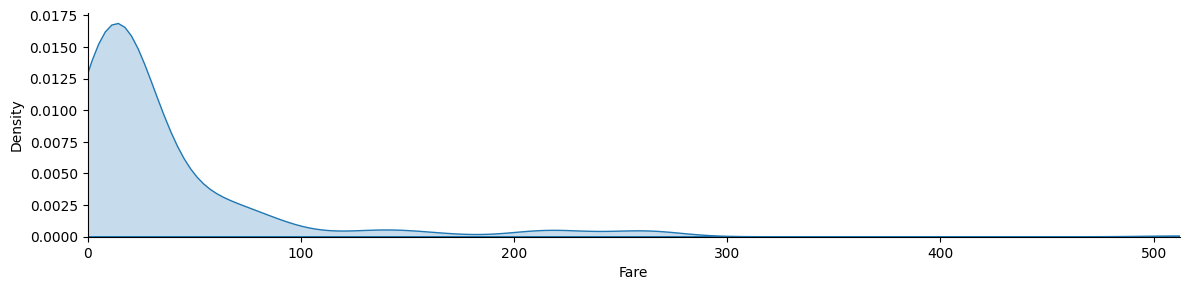

In [3]:
#Plotting distribution of Fare column in test data
a = sns.FacetGrid(df_test, aspect=4)
a.map(sns.kdeplot, "Fare", shade=True)
a.set(xlim=(0, df_test["Fare"].max()))

print("Skew of test data for Fare feature: ", df_test.Fare.skew())

In [4]:
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
#using median since Fare data is heavily right skewed
df_test["Fare"] = df_test["Fare"].fillna(df["Fare"].median())
#Feature to show rows with missing values in Age column
df["Age_NA"] = np.where(df["Age"].isnull(), 1, 0)
df_test["Age_NA"] = np.where(df_test["Age"].isnull(), 1, 0)

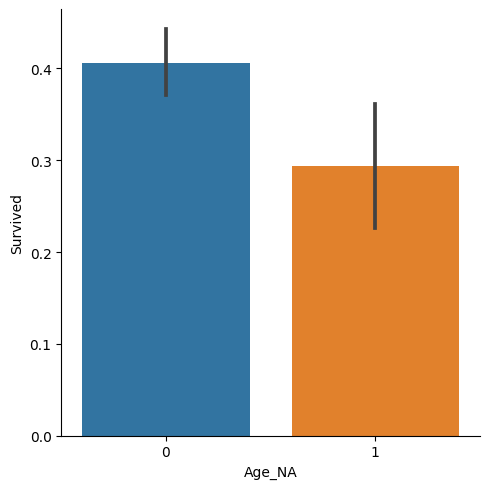

In [5]:
#Visualizing Age_NA vs Survival
sns.catplot(x = "Age_NA", y = "Survived", data=df, kind="bar")

skew of Age data:  0.38910778230082693


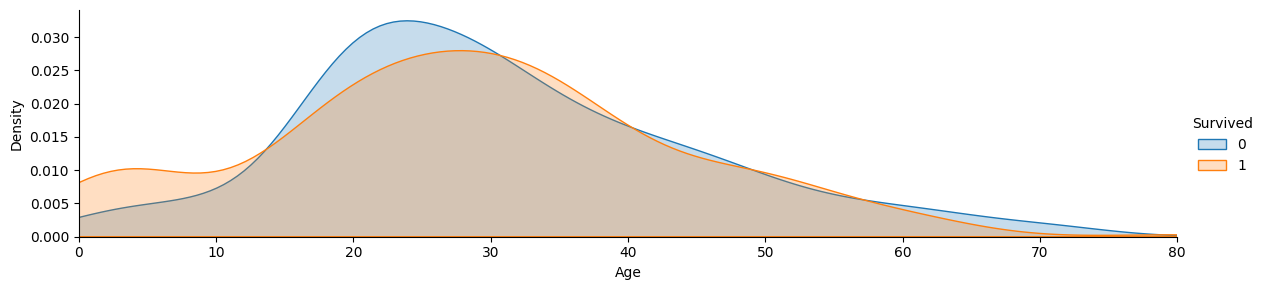

In [6]:
#Plotting distribution of Age column
a = sns.FacetGrid(df, hue="Survived", aspect=4)
a.map(sns.kdeplot, "Age", shade=True)
a.set(xlim=(0, df["Age"].max()))
a.add_legend()

print("skew of Age data: ", df["Age"].skew())

ticket_type
NO         0.746352
OTHER_T    0.099888
PC         0.067340
CA         0.046016
A5         0.023569
SOTONOQ    0.016835
Name: count, dtype: float64


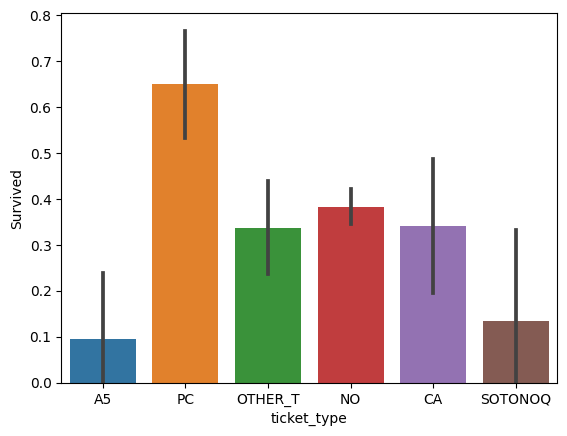

In [7]:
#Since distribution is almost normal so mean imputation is done for Age column
df["Age_mean"] = np.where(df["Age"].isnull(), df["Age"].mean(), df["Age"])
df_test["Age_mean"] = np.where(df_test["Age"].isnull(), df_test["Age"].mean(), df_test["Age"])

def ticket_sep(ticket_data):
    ticket_type = []
    for i in range(len(ticket_data)):
        ticket = ticket_data.iloc[i]
        for c in string.punctuation:
            ticket = ticket.replace(c, "")
        splitted_ticket = ticket.split(" ")
        if len(splitted_ticket) == 1:
            ticket_type.append("NO")
        else:
            ticket_type.append(splitted_ticket[0])
    return ticket_type

df["ticket_type"] = ticket_sep(df["Ticket"])
df_test["ticket_type"] = ticket_sep(df_test["Ticket"])

for i in df["ticket_type"].unique():
    if len(df[df.ticket_type == i]) < 15:
        df.loc[df.ticket_type == i, "ticket_type"] = "OTHER_T"

for l in df_test["ticket_type"].unique():
    if l not in df["ticket_type"].unique():
        df_test.loc[df_test.ticket_type == l, "ticket_type"] = "OTHER_T"

#visualization of ticket_type feature
sns.barplot(x="ticket_type", y="Survived", data=df)
print(df["ticket_type"].value_counts()/len(df))

Since SOTONOQ and A5 have very low survival rate and are rare categories, so let's combine them

In [8]:
df.loc[df.ticket_type == "SOTONOQ", "ticket_type"] = "A5"
df_test.loc[df_test.ticket_type == "SOTONOQ", "ticket_type"] = "A5"

#sns.barplot(x="ticket_type", y="Survived", data=df)
#print(df["ticket_type"].value_counts()/len(df))

#drop ticket feature from the dataset
df = df.drop(["Ticket"], axis=1)
df_test = df_test.drop(["Ticket"], axis=1)

cabin_type
NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: count, dtype: int64


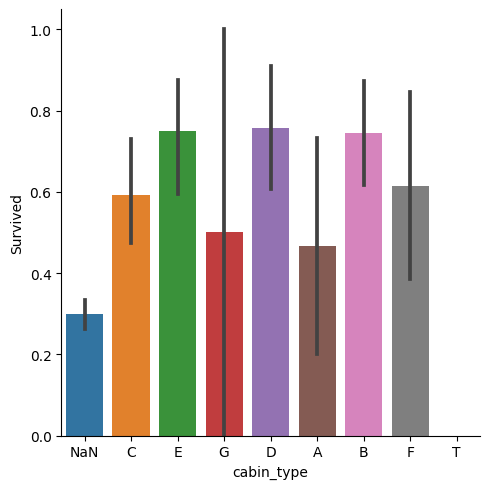

In [9]:
def cabin_sep(data_cabin):
    cabin_type = []
    for i in range(len(data_cabin)):
        if data_cabin.isnull().iloc[i] == True:
            cabin_type.append("NaN")
        else:
            cabin_type.append(data_cabin.iloc[i][:1])
    return cabin_type

df["cabin_type"] = cabin_sep(df["Cabin"])
df_test["cabin_type"] = cabin_sep(df_test["Cabin"])

print(df.cabin_type.value_counts())
#Visualization of cabin_type
sns.catplot(x="cabin_type", y="Survived", data=df, kind="bar", aspect=1)

To make cabin_type data representative, let's combine values having count<=15

cabin_type
NaN        0.771044
C          0.066218
B          0.052750
OTHER_C    0.037037
D          0.037037
E          0.035915
Name: count, dtype: float64


<Axes: xlabel='cabin_type', ylabel='Survived'>

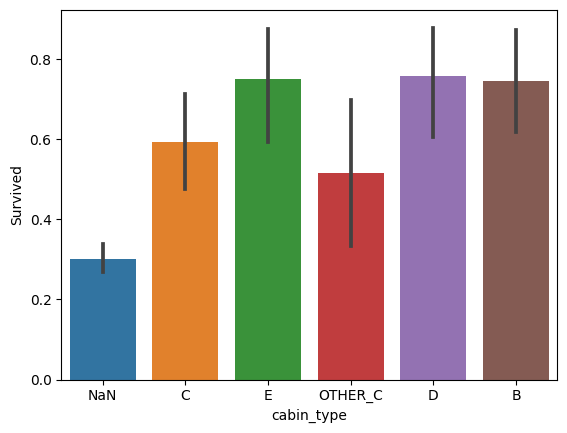

In [10]:
for j in df.cabin_type.unique():
    if len(df[df.cabin_type == j]) <= 15:
        df.loc[df.cabin_type == j, "cabin_type"] = "OTHER_C"

for k in df_test.cabin_type.unique():
    if k not in df.cabin_type.unique():
        df_test.loc[df_test.cabin_type == k, "cabin_type"] = "OTHER_C"

#Visualization of cabin_type vs survival
print(df["cabin_type"].value_counts()/len(df))
sns.barplot(x="cabin_type",y="Survived", data=df)

In [11]:
#drop cabin columns
df = df.drop(["Cabin"], axis=1)
df_test = df_test.drop(["Cabin"], axis=1)

In [12]:
def name_sep(data_name):
    families = []
    titles = []
    new_name = []
    for i in range(len(data_name)):
        name = data_name.iloc[i]
        if "(" in name:
            name_no_bracket = name.split("(")[0]
        else:
            name_no_bracket = name

        family = name_no_bracket.split(",")[0]
        title = name_no_bracket.split(",")[1].strip().split(" ")[0]

        #remove punctuations
        for c in string.punctuation:
            name = name.replace(c, "").strip()
            family = family.replace(c, "").strip()
            title = title.replace(c, "").strip()

        families.append(family)
        titles.append(title)
        new_name.append(name)

    return families, titles, new_name

df["family"], df["title"], df["Name"] = name_sep(df["Name"])
df_test["family"], df_test["title"], df_test["Name"] = name_sep(df_test["Name"])

title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
the           1
Jonkheer      1
Name: count, dtype: int64


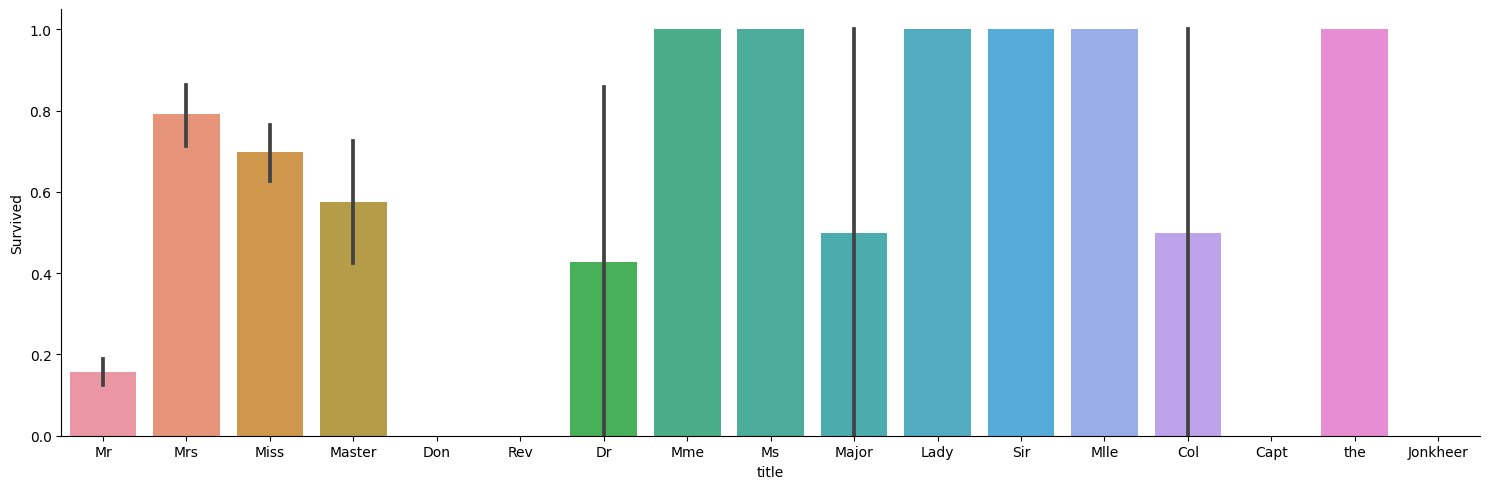

In [13]:
print(df.title.value_counts())
sns.catplot(x="title",y="Survived",kind="bar",data=df, aspect=3)

In [14]:
for r in df.title.unique():
    if len(df[df.title == r]) <= 15:
        df.loc[df.title == r, "title"] = "OTHER"

for r in df_test.title.unique():
    if r not in df.title.unique():
        df_test.loc[df_test.title == r, "title"] = "OTHER"

<Axes: xlabel='title', ylabel='Survived'>

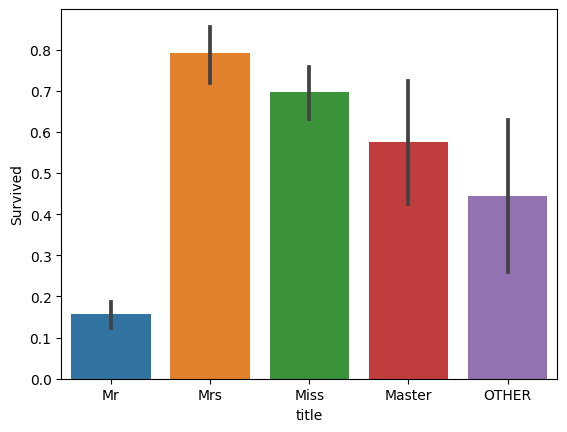

In [15]:
sns.barplot(x="title", y="Survived", data=df)

According to the plot above, there is definately some correlation between title and survival

In [16]:
overlap = [x for x in df.family.unique() if x in df_test.family.unique()]
non_overlap_train = [x for x in df.family.unique() if x not in df_test.family.unique()]
non_overlap_test = [x for x in df_test.family.unique() if x not in df.family.unique()]

print(len(overlap))
print(len(non_overlap_train))
print(len(non_overlap_test))

144
523
208


In [17]:
#Creating new feature family_size
df["family_size"] = df["SibSp"]+df["Parch"]+1
df_test["family_size"] = df_test.SibSp+df_test.Parch+1

#Creating new feature to store information of overlapping and non-overlapping
family_count = df["family"].value_counts().to_dict()
df["family"] = df["family"].astype(str)
df["family_count"] = df.family.map(family_count)

family_count = df_test["family"].value_counts().to_dict()
df_test["family"] = df_test["family"].astype(str)
df_test["family_count"] = df_test.family.map(family_count)

In [18]:
df = df.drop(["Name", "family"], axis=1)
df_test = df_test.drop(["Name", "family"], axis=1)

# **Dealing with Outliers and Rare values**

In [19]:
useful_cols_1 = [col for col in df.columns if col not in ["PassengerId","Survived","kfold"]]
num_cols_1 = [col for col in useful_cols_1 if df[col].dtype in ["int64", "float64"]]
num_cols_1

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_NA',
 'Age_mean',
 'family_size',
 'family_count']

outliers can be in Age, Age_mean and Fare

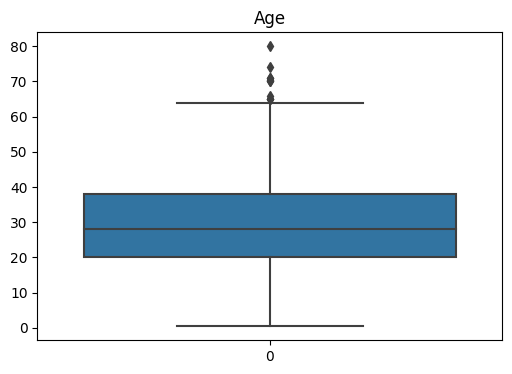

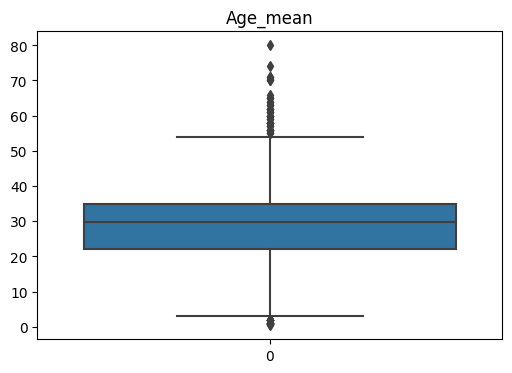

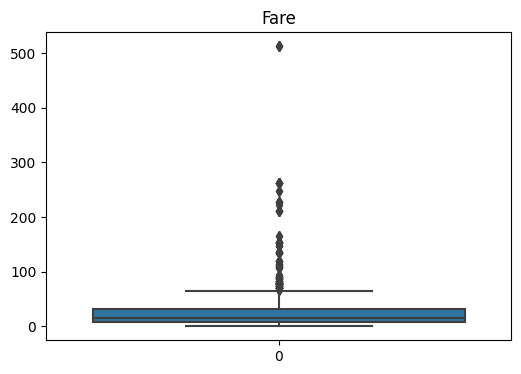

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(df.Age)
plt.title("Age")

plt.figure(figsize=(6,4))
sns.boxplot(df.Age_mean)
plt.title("Age_mean")

plt.figure(figsize=(6,4))
sns.boxplot(df.Fare)
plt.title("Fare")

plt.show()

All the 3 features have outliers. It can be dangerous to linear models(doesn't matter much to tree models).
The method to handle outliers depend on the distribution of the features.
1. If normal distribution --> bound values within 3std(sigma) range.
2. If skewed distribution --> bound values within 3IQR range.

skew for Age:  0.38910778230082693
skew for Age_mean:  0.4344880940129924
skew for Fare:  4.787316519674893


<Figure size 640x480 with 0 Axes>

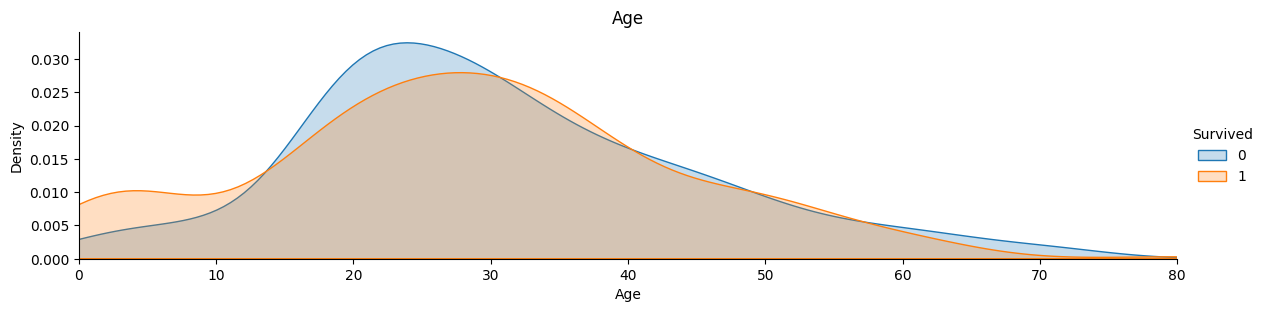

<Figure size 640x480 with 0 Axes>

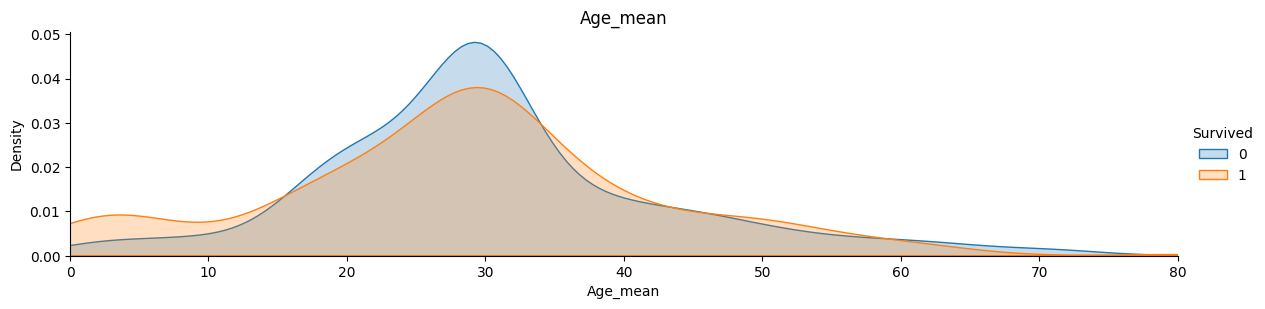

<Figure size 640x480 with 0 Axes>

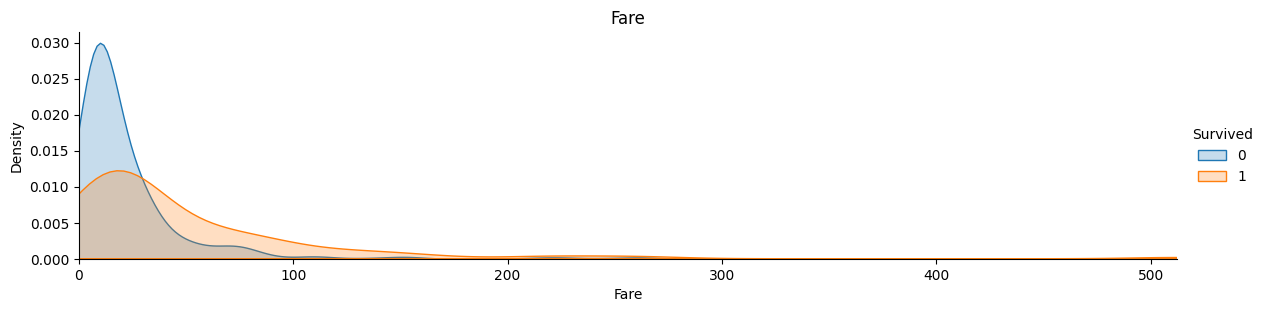

In [21]:
#Checking distribution of features
plt.figure()
a = sns.FacetGrid(df, hue="Survived", aspect=4)
a.map(sns.kdeplot, "Age", fill=True)
a.set(xlim=(0, df["Age"].max()))
a.add_legend()
print("skew for Age: ", df.Age.skew())
plt.title("Age")

plt.figure()
a = sns.FacetGrid(df, hue="Survived", aspect=4)
a.map(sns.kdeplot, "Age_mean", fill=True)
a.set(xlim=(0, df["Age_mean"].max()))
a.add_legend()
print("skew for Age_mean: ", df.Age_mean.skew())
plt.title("Age_mean")

plt.figure()
a = sns.FacetGrid(df, hue="Survived", aspect=4)
a.map(sns.kdeplot, "Fare", fill=True)
a.set(xlim=(0, df["Fare"].max()))
a.add_legend()
print("skew for Fare: ", df.Fare.skew())
plt.title("Fare")

plt.show()

In [22]:
print(f"Max_Age: {df.Age.max()} and Min_Age: {df.Age.min()}")
print(f"Max_Age_mean: {df.Age_mean.max()} and Min_Age_mean: {df.Age_mean.min()}")
print(f"Max_Fare: {df.Fare.max()} and Min_Fare: {df.Fare.min()}")

Max_Age: 80.0 and Min_Age: 0.42
Max_Age_mean: 80.0 and Min_Age_mean: 0.42
Max_Fare: 512.3292 and Min_Fare: 0.0


From the plot it is clear that Age and Age_mean has normal distribution and Fare has skewed distribution.

In [23]:
#Calculating upper bound and lower bound for Age and limiting values within 3sigma
age_mean = df.Age.mean()
age_std = df.Age.std()

upper_age = age_mean + 3*age_std
lower_age = age_mean - 3*age_std

df.loc[df.Age > upper_age, "Age"] = upper_age
df.loc[df.Age < lower_age, "Age"] = lower_age

df_test.loc[df_test.Age > upper_age, "Age"] = upper_age
df_test.loc[df_test.Age < lower_age, "Age"] = lower_age

#Calculating upper bound and lower bound for Age_mean and limiting values within 3sigma
age_m_mean = df.Age_mean.mean()
age_m_std = df.Age_mean.std()

upper_age_m = age_m_mean + 3*age_m_std
lower_age_m = age_m_mean - 3*age_m_std

df.loc[df.Age > upper_age_m, "Age"] = upper_age_m
df.loc[df.Age < lower_age_m, "Age"] = lower_age_m

df_test.loc[df_test.Age > upper_age_m, "Age"] = upper_age_m
df_test.loc[df_test.Age < lower_age_m, "Age"] = lower_age_m

#Calculating upper bound and lower bound for Fare and limiting values within 3IQR
IQR = df.Fare.quantile(0.75) - df.Fare.quantile(0.25)

upper_fare = df.Fare.quantile(0.75) + 3*IQR
lower_fare = df.Fare.quantile(0.25) - 3*IQR

df.loc[df.Fare > upper_fare, "Fare"] = upper_fare
df.loc[df.Fare < lower_fare, "Fare"] = lower_fare

df_test.loc[df_test.Fare > upper_fare, "Fare"] = upper_fare
df_test.loc[df_test.Fare < lower_fare, "Fare"] = lower_fare

In [24]:
print(f"New_Max_Age: {df.Age.max()} and New_Min_Age: {df.Age.min()}")
print(f"New_Max_Age_mean: {df.Age_mean.max()} and New_Min_Age_mean: {df.Age_mean.min()}")
print(f"New_Max_Fare: {df.Fare.max()} and New_Min_Fare: {df.Fare.min()}")

New_Max_Age: 68.70516332506747 and New_Min_Age: 0.42
New_Max_Age_mean: 80.0 and New_Min_Age_mean: 0.42
New_Max_Fare: 100.2688 and New_Min_Fare: 0.0


It is important to deal with rare values. 
Rare values in categorical variables are those values their either appear in training data or test data and it can overfit the model by adding noise with little info, especially in tree models.

In [25]:
#High cardinal categoricals have been dropped and now left are:
columns = ["Parch", "SibSp", "Embarked", "Sex", "Pclass"]

for col in columns:
    print(col)
    print(df[col].unique())
    print(df_test[col].unique())

Parch
[0 1 2 5 3 4 6]
[0 1 3 2 4 6 5 9]
SibSp
[1 0 3 4 2 5 8]
[0 1 2 3 4 5 8]
Embarked
['S' 'C' 'Q']
['Q' 'S' 'C']
Sex
['male' 'female']
['male' 'female']
Pclass
[3 1 2]
[3 2 1]


As we can see value 9 in Parch column is a rare value appearing only in test column. to deal with it, we can drop Parch and SibSp as family_size feature is more representative feature for predicting survival. It will be more clear with correlation graph after some time.

Hypothesis: family_size feature is better representative than Parch and SibSp tp predict survival.

Testing method used: catplot and correlation graph

In [26]:
#checking for rare values in family_size feature
print(df.family_size.unique())
print(df_test.family_size.unique())

[ 2  1  5  3  7  6  4  8 11]
[ 1  2  3  5  4  6  8  7 11]


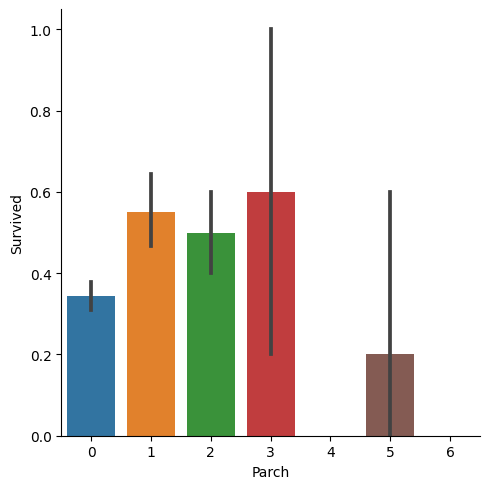

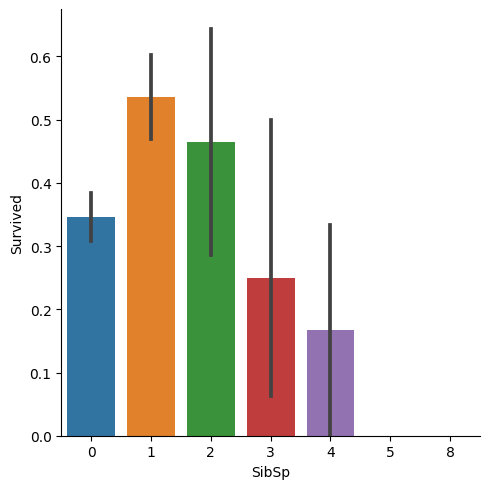

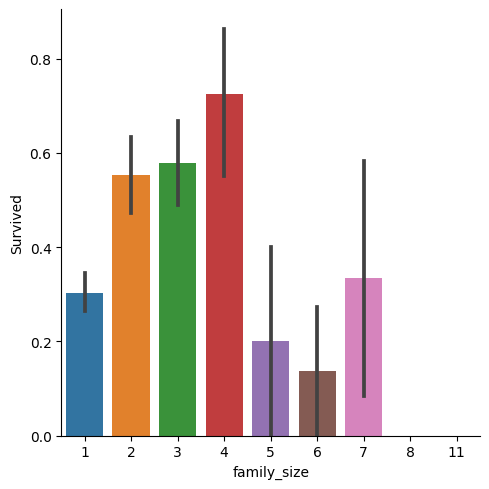

In [27]:
#visualization
sns.catplot(x="Parch", y="Survived", kind="bar", data=df)
sns.catplot(x="SibSp", y="Survived", kind="bar", data=df)
sns.catplot(x="family_size", y="Survived", kind="bar", data=df)

Accoding to plots above, family_size has less variability than Parch and SibSp, so combining them performs better than using them separately for survival prediction.

# **Predicting missing Age values using Kernel Ridge**

In [28]:
#combining training and test data
data = pd.concat([df.drop(["Survived","kfold"], axis=1), df_test], axis=0, sort=False)

In [29]:
train = data.dropna()
test = data[pd.isnull(data.Age)]

In [30]:
#Creating folds
train["KF"] = -1
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=train)):
    train.iloc[valid_idx, train.columns.get_loc("KF")] = fold

train["KF"] = train["KF"].astype(int)
train["family_size"] = train["family_size"].astype(int)
train["family_count"] = train["family_count"].astype(int)

In [31]:
#useful_colm = [col for col in train.columns if col not in ["PassengerId", "KF"]]
#cat_colm = ["Pclass","SibSp","Parch","Sex", "Embarked", "cabin_type", "ticket_type", "title"]
#num_colm = [col for col in useful_colm if col not in cat_colm]

In [32]:
print(train.shape)
print(test.shape)

(1046, 16)
(263, 15)


In [33]:
colm = ['Sex', 'Embarked', 'ticket_type', 'cabin_type', 'title']
train_ = []
test_ = []
for fold in range(10):
    xtrain = train.loc[train.KF != fold, colm]
    xvalid = train.loc[train.KF == fold, colm]
    xtest = test[colm].copy()

    #label encoding
    for c in colm:
        le = preprocessing.LabelEncoder()
        xtrain[c] = le.fit_transform(xtrain[c])
        xvalid[c] = le.transform(xvalid[c])
        xtest[c] = le.transform(xtest[c])

    comb = pd.concat([xtrain, xvalid], axis=0, sort=False)
    train_.append(comb)
    test_.append(xtest)

#train__ = pd.concat(train_)
#test__ = pd.concat(test_)

#train__[num_colm] = train__[num_colm].groupby(level=0).mean()
#test__[num_colm] = test__[num_colm].groupby(level=0).mean()

train_mode = pd.concat(train_).groupby(level=0).agg(lambda x: x.mode().iloc[0])
test_mode = pd.concat(test_).groupby(level=0).agg(lambda x: x.mode().iloc[0])

train__ = pd.DataFrame(train_mode)
test__ = pd.DataFrame(test_mode)

train = train.drop(colm, axis=1)
test = test.drop(colm, axis=1)

#train = pd.concat([train,train__], axis=1, sort=False)
#test = pd.concat([test,test__], axis=1, sort=False)

In [34]:
#Merging train__ on train dataframe instead of using concat with axis=1 as it is index sensitive in case of axis=1
train = train.merge(train__, left_index=True, right_index=True, how="left")
test = test.merge(test__, left_index=True, right_index=True, how="left")

In [35]:
obs_data = pd.concat([train, test], axis=0, sort=False)

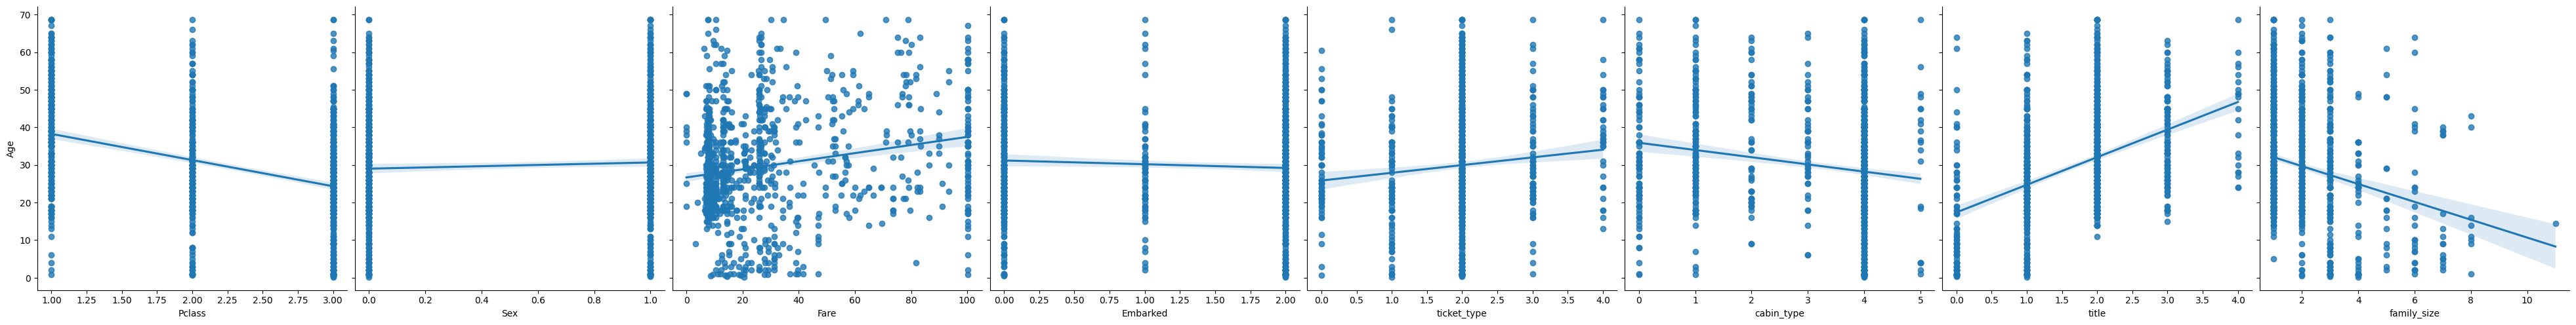

In [36]:
#Visualizing correlation with Age
sns.pairplot(obs_data, x_vars=['Pclass', 'Sex','Fare','Embarked','ticket_type',
                           'cabin_type','title','family_size'], 
             y_vars='Age',size=5,kind='reg')

<Axes: title={'center': 'Pearson Correlation of Features'}>

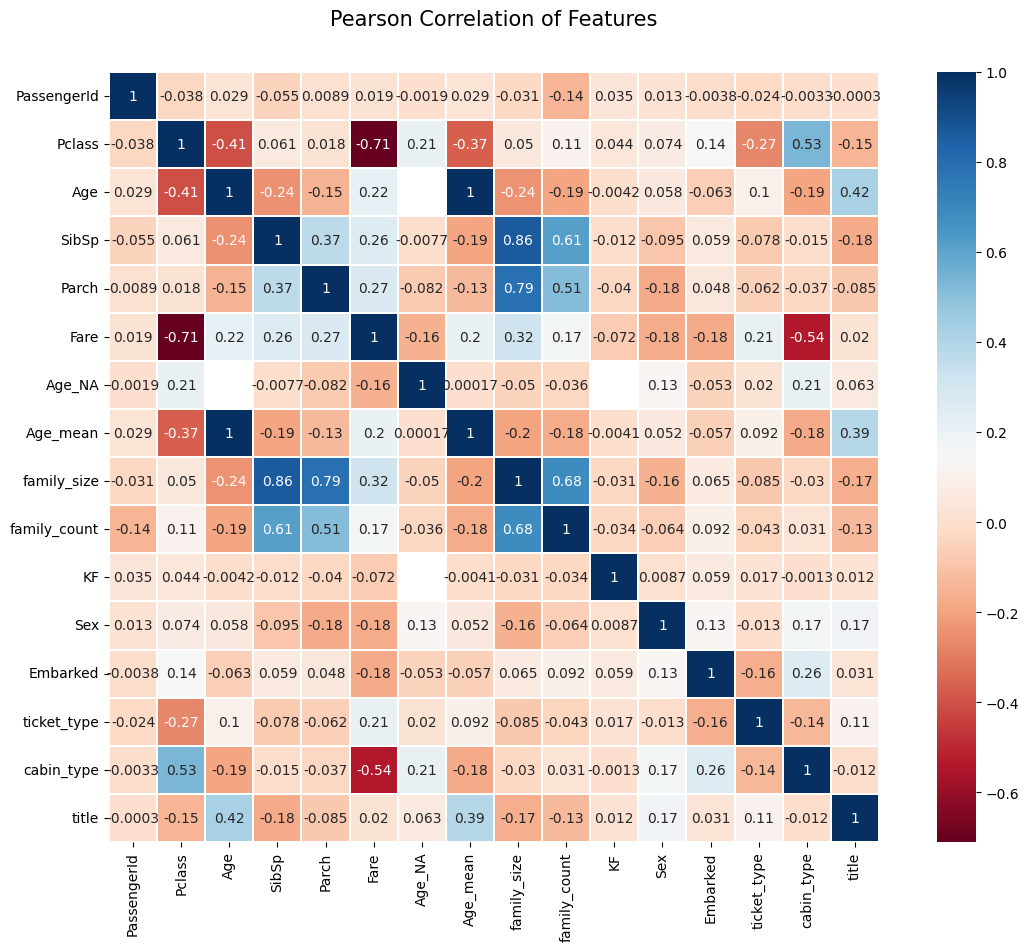

In [37]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(obs_data.corr(), linewidths=0.1, vmax=1.0, square=True, 
            linecolor="white",cmap=colormap, annot=True )

According to pairplot and heatmap, Age_mean has high correlation with Age and Age_NA has no correlation with Age, so we need to drop these columns.

In [38]:
train = train.drop(["Age_mean", "Age_NA"], axis=1)
test = test.drop(["Age_mean", "Age_NA"], axis=1)

In [39]:
useful_colm = [col for col in train.columns if col not in ["PassengerId", "KF", "Age"]]

In [40]:
#Using kernel Ridge and Standard Scaler to predict Age missing values
#Hyperparameter Grid
gammas = [0.001,0.01,0.1,1,10,100,1000]
kernels = ["rbf", "linear"]
alphas = [0.001,0.01,0.1,1,10,100,1000]

best_score = -np.inf
best_params = {}
fold_scores = []

for gamma in gammas:
    for kernel in kernels:
        for alpha in alphas:
            scores = []
            for folds in range(10):
                xtrain = train[train.KF != fold]
                xvalid = train[train.KF == fold]

                ytrain = xtrain.Age
                yvalid = xvalid.Age

                xtrain = xtrain[useful_colm]
                xvalid = xvalid[useful_colm]

                model = make_pipeline(preprocessing.StandardScaler(), KernelRidge(
                    gamma = gamma,
                    kernel = kernel,
                    alpha = alpha
                ))

                model.fit(xtrain, ytrain)
                preds = model.predict(xvalid)
                score = metrics.r2_score(yvalid, preds)
                scores.append(score)
                
            avg_score = np.mean(scores)
            fold_scores.append(((gamma, kernel, alpha), avg_score))

            if avg_score > best_score:
                best_score = avg_score
                best_params = {"gamma":gamma, "kernel":kernel, "alpha":alpha}

print("Best Parameters are: ", best_params)
print("Best average R² score: ", best_score)

Best Parameters are:  {'gamma': 0.01, 'kernel': 'rbf', 'alpha': 0.01}
Best average R² score:  0.3629000678302914


In [41]:
#Final prediction
useful_colm_test = [col for col in test.columns if col not in ["PassengerId", "Age"]]

y_train = train.Age
X_train = train[useful_colm]
X_test = test[useful_colm_test]

final_model = make_pipeline(preprocessing.StandardScaler(), KernelRidge(**best_params))
final_model.fit(X_train, y_train)
y_test = final_model.predict(X_test)

In [42]:
data.loc[pd.isnull(data.Age), "Age"] = y_test

In [43]:
idx = int(df.shape[0])
df['Age'] = data.iloc[:idx].Age
df_test['Age'] = data.iloc[idx:].Age

Skew of Age feature:  0.3149737308099556


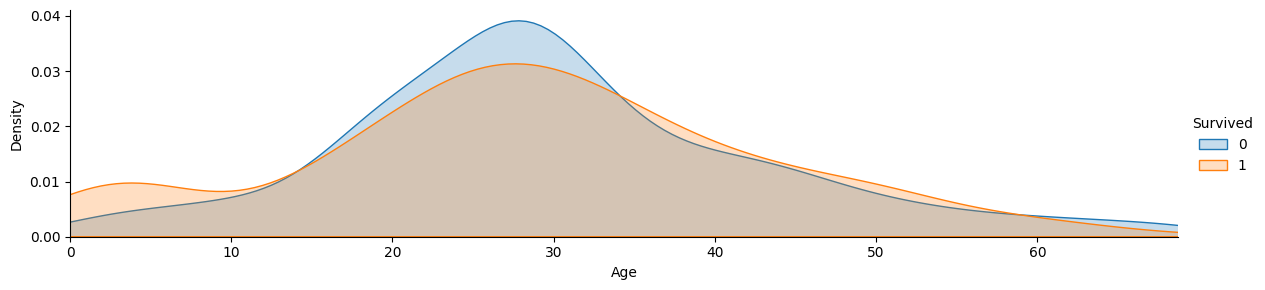

In [44]:
#Distribution of Age vs Survival
a = sns.FacetGrid(df, hue="Survived", aspect=4)
a.map(sns.kdeplot, "Age", shade=True)
a.set(xlim=(0, df.Age.max()))
a.add_legend()

print("Skew of Age feature: ", df.Age.skew())

As seen earlier, Age and Age_mean are fully correlated and SibSp and Parch are highly correlated, so drop Age_mean, Sibsp and Parch from training and test data

In [45]:
drop_col = ["Age_mean", "SibSp", "Parch"]
df = df.drop(drop_col, axis=1)
df_test = df_test.drop(drop_col, axis=1)

# **Feature Encoding**

We will try four types of encoding strategies and will compare their perfomances.

**1. One-Hot Encoding**

In [46]:
onehot_columns = ["cabin_type", "title", "Sex", "Embarked", "ticket_type", "Pclass"]

In [47]:
train_onehot = df.copy()
test_onehot = df_test.copy()

In [48]:
for col in onehot_columns:
    train_onehot = pd.concat([train_onehot, pd.get_dummies(df[col], drop_first=True, dtype=int)], axis=1)
    test_onehot = pd.concat([test_onehot, pd.get_dummies(df_test[col], drop_first=True, dtype=int)], axis=1)

In [49]:
train_onehot = train_onehot.drop(onehot_columns, axis=1)
test_onehot = test_onehot.drop(onehot_columns, axis=1)

<Figure size 1800x1000 with 0 Axes>

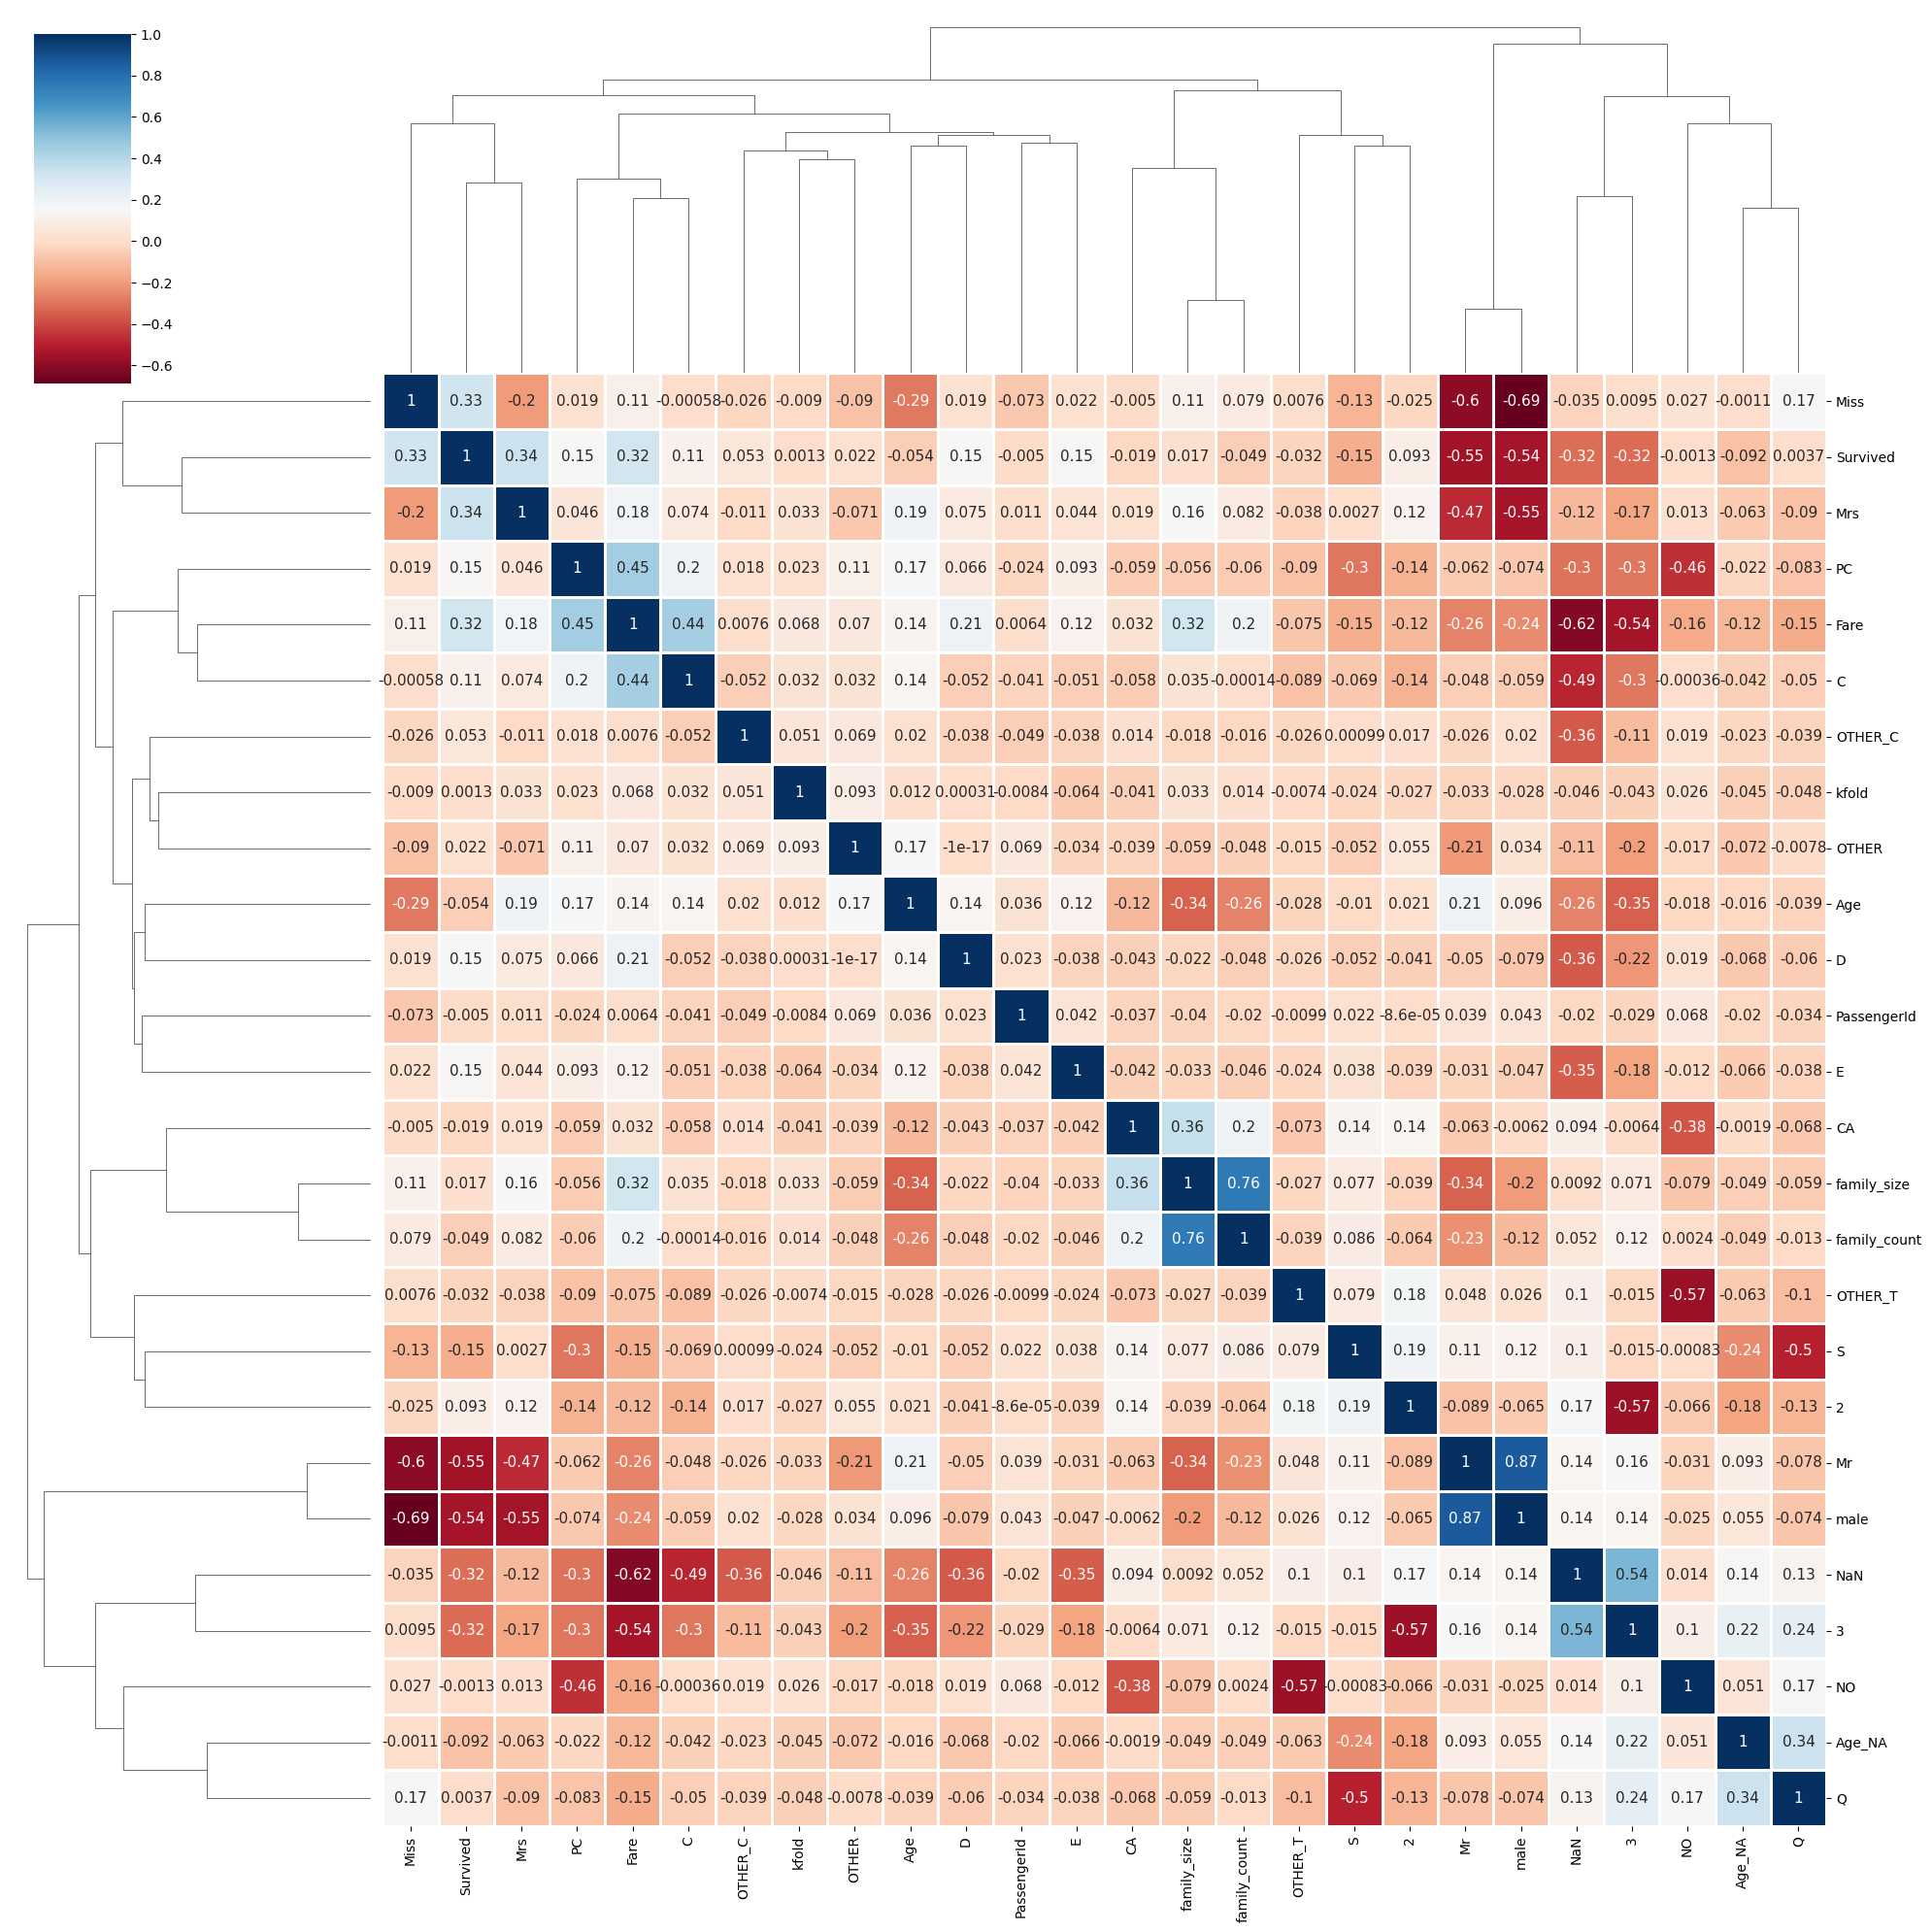

In [50]:
#Visualization of correlation of features better than heatmap
plt.figure(figsize=(18,10))
sns.clustermap(train_onehot.corr(), linewidths=0.8, vmax=1.0, 
               square=True, linecolor="white", cmap=colormap, figsize=(20,20),
               annot=True, annot_kws={"size":11})
plt.show()

**2. Label Encoding**

In [51]:
train_label = df.copy()
test_label = df_test.copy()

In [52]:
label_col = ['Sex', 'Embarked', 'ticket_type', 'cabin_type', 'title']
train_label_ = []
test_label_ = []
for fold in range(10):
    xtrain = train_label.loc[train_label.kfold != fold, label_col]
    xvalid = train_label.loc[train_label.kfold == fold, label_col]
    xtest = test_label[label_col].copy()

    #label encoding
    for c in colm:
        le = preprocessing.LabelEncoder()
        xtrain[c] = le.fit_transform(xtrain[c])
        xvalid[c] = le.transform(xvalid[c])
        xtest[c] = le.transform(xtest[c])

    comb = pd.concat([xtrain, xvalid], axis=0, sort=False)
    train_label_.append(comb)
    test_label_.append(xtest)

train_label_mode = pd.concat(train_label_).groupby(level=0).agg(lambda x: x.mode().iloc[0])
test_label_mode = pd.concat(test_label_).groupby(level=0).agg(lambda x: x.mode().iloc[0])

train__label_ = pd.DataFrame(train_label_mode)
test__label_ = pd.DataFrame(test_label_mode)

train_label = train_label.drop(label_col, axis=1)
test_label = test_label.drop(label_col, axis=1)

In [53]:
train_label = train_label.merge(train__label_, left_index=True, right_index=True, how="left")
test_label = test_label.merge(test__label_, left_index=True, right_index=True, how="left")

<Figure size 1800x1000 with 0 Axes>

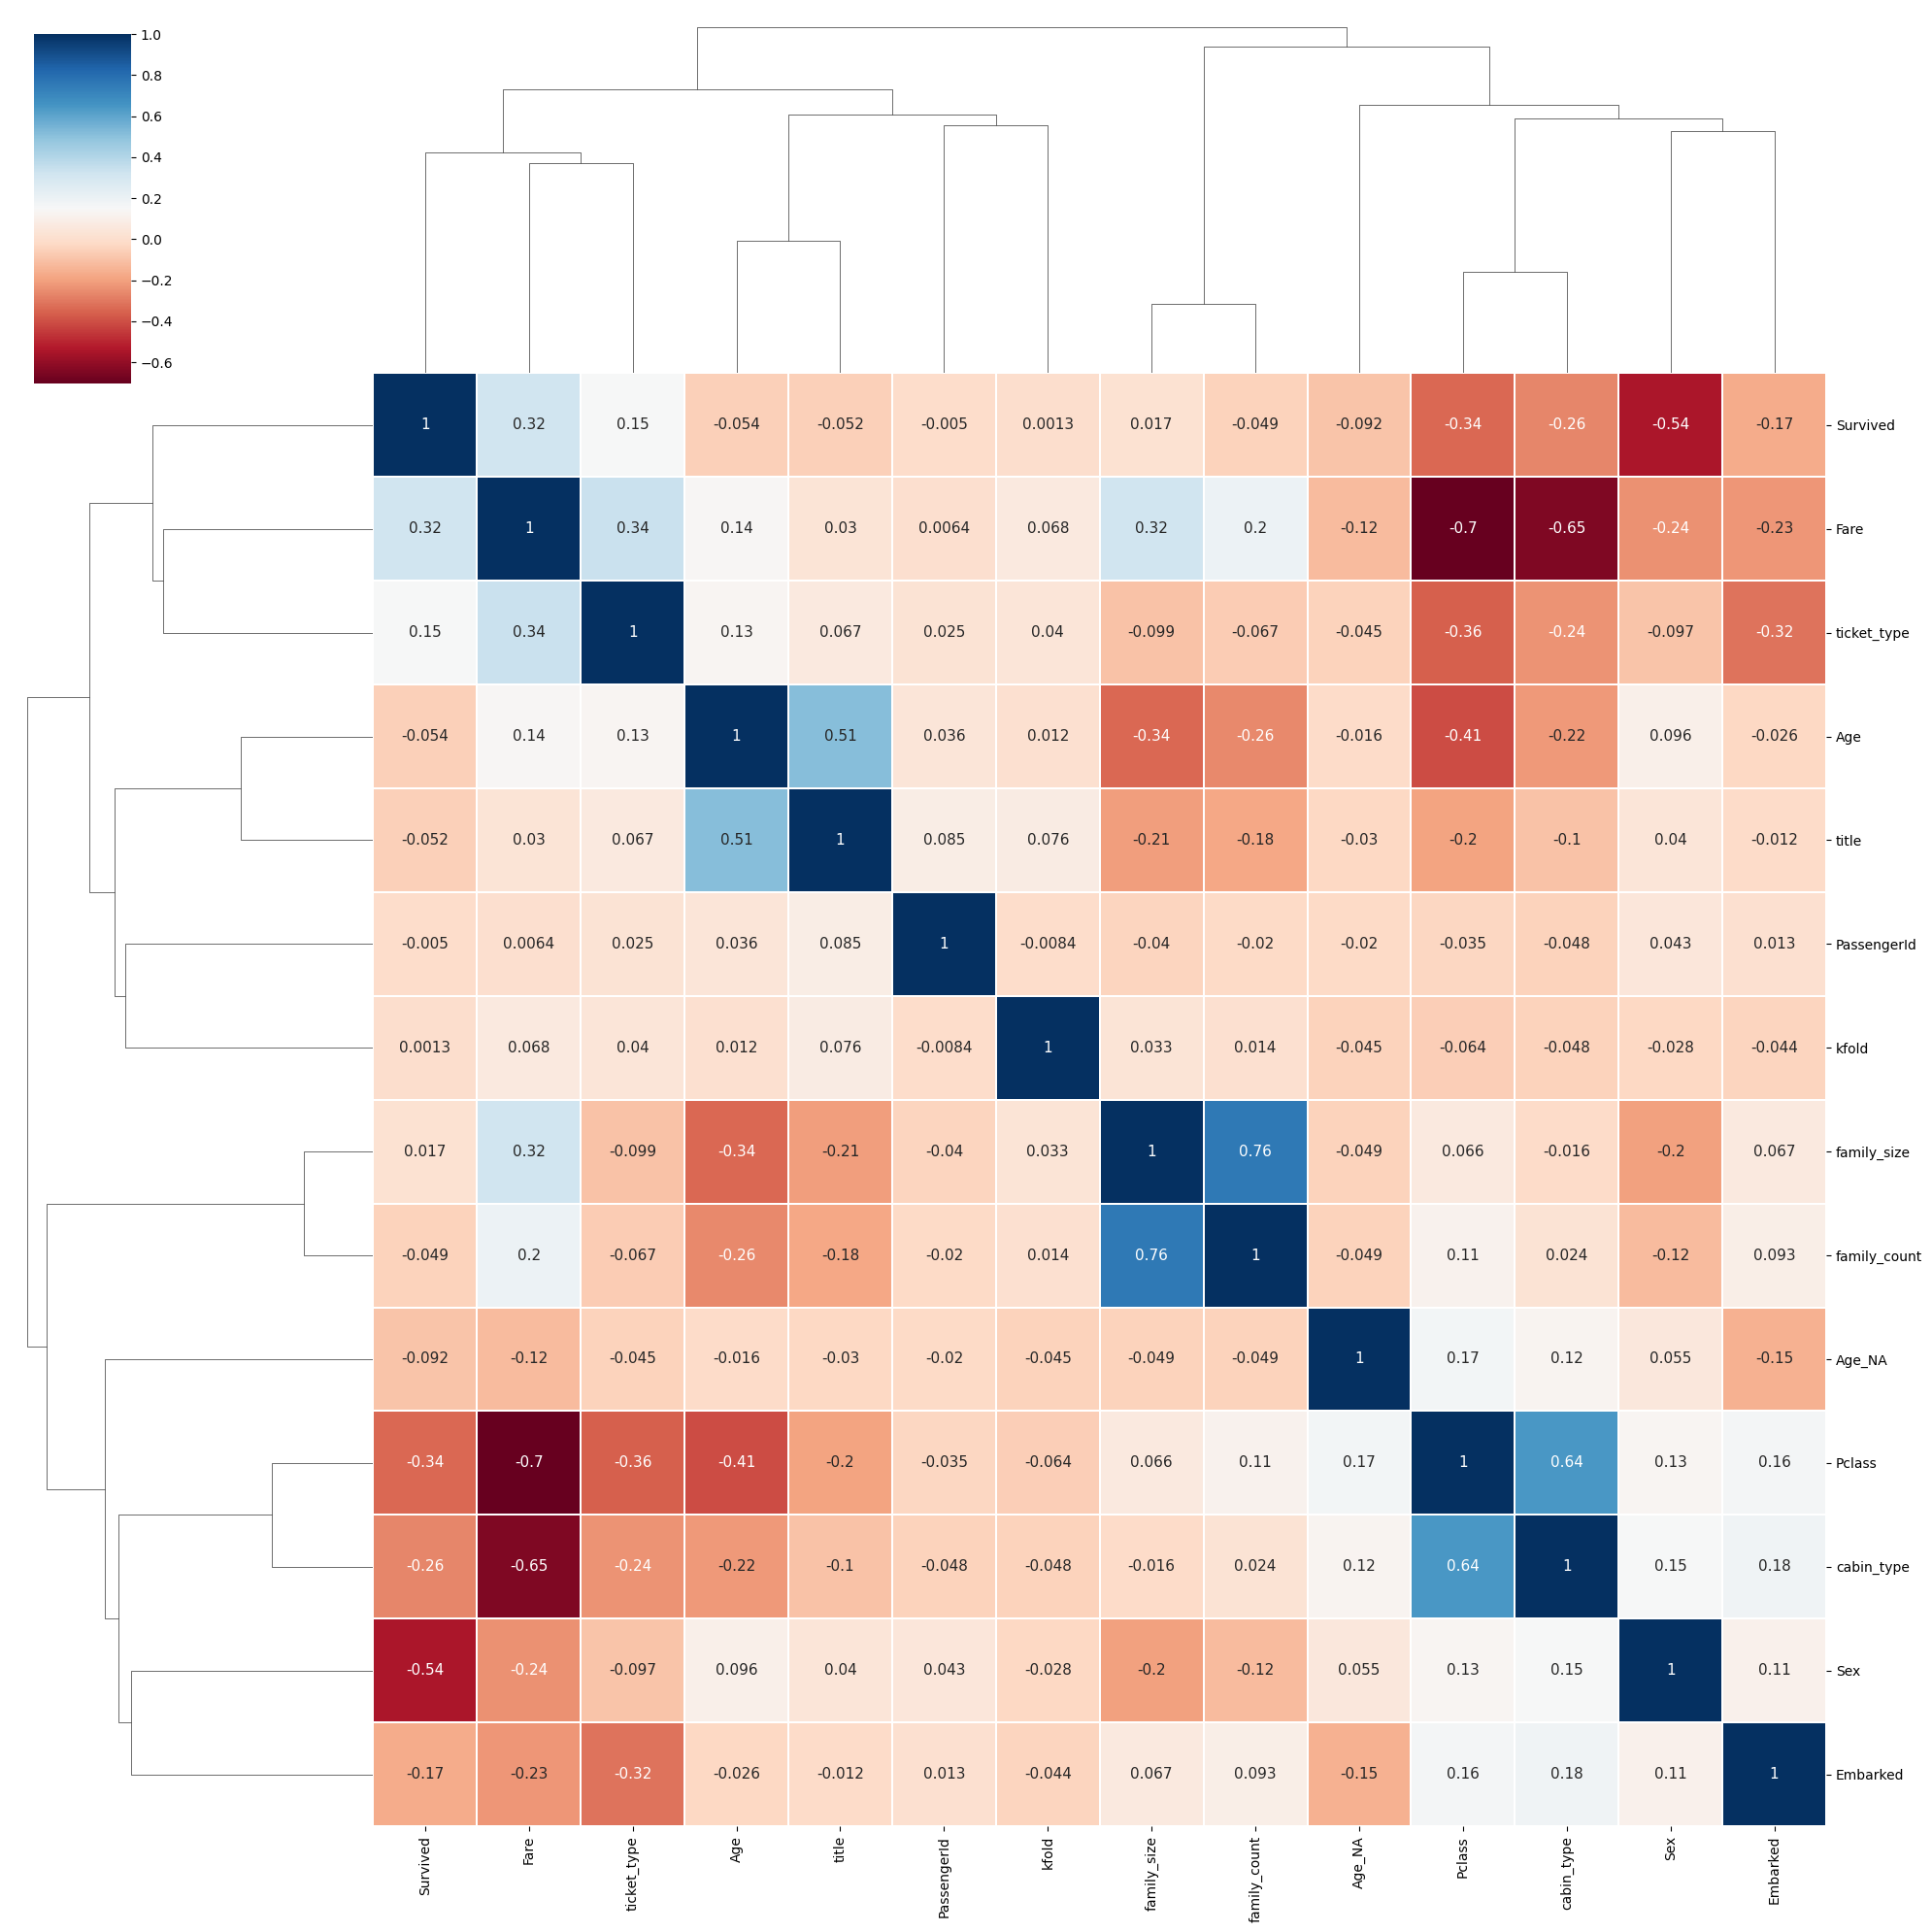

In [54]:
#Visualization of correlation of features
plt.figure(figsize=(18,10))
sns.clustermap(train_label.corr(), linewidths=0.1, vmax=1.0, 
               square=True, linecolor="white", cmap=colormap, annot=True,
               annot_kws={"size":11}, figsize=(20,20))
plt.show()

**3. Mean Encoder**

In [55]:
train_mean = df.copy()
test_mean = df_test.copy()

In [56]:
mean_col = ['Sex', 'Embarked', 'ticket_type', 'cabin_type', 'title']

In [57]:
final_train = train_mean.copy()
for col in mean_col:
    final_col = pd.Series(index=final_train.index, dtype=float)
    test_col = pd.DataFrame()
    for fold in range(5):
        fold_train = train_mean[train_mean.kfold != fold]
        fold_valid = train_mean[train_mean.kfold == fold]
        #fold_test = test_mean.copy()
        
        fold_mean = fold_train.groupby(col)["Survived"].mean().to_dict()

        final_col.loc[fold_valid.index] = fold_valid[col].map(fold_mean)
        test_col[f"{col}_enc_{fold}"] = test_mean[col].map(fold_mean)

    #global mean
    global_mean = train_mean["Survived"].mean()
    final_col.fillna(global_mean, inplace=True)
    final_train[col + "_enc"] = final_col

    test_mean[col + "_enc"] = test_col.mean(axis=1)
    test_mean[col + "_enc"].fillna(global_mean, inplace=True)

train_mean = final_train

In [58]:
train_mean = train_mean.drop(mean_col, axis=1)
test_mean = test_mean.drop(mean_col, axis=1)

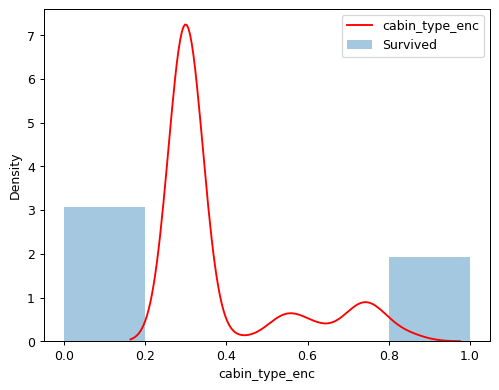

In [59]:
#Visualisation
plt.figure(dpi=90)
ax = sns.distplot(train_mean.Survived, kde=False, norm_hist=True)
ax = sns.kdeplot(train_mean.cabin_type_enc, color='r', ax=ax)
ax.set_xlabel("cabin_type_enc")
ax.legend(labels=['cabin_type_enc', 'Survived'])

<Figure size 1800x1000 with 0 Axes>

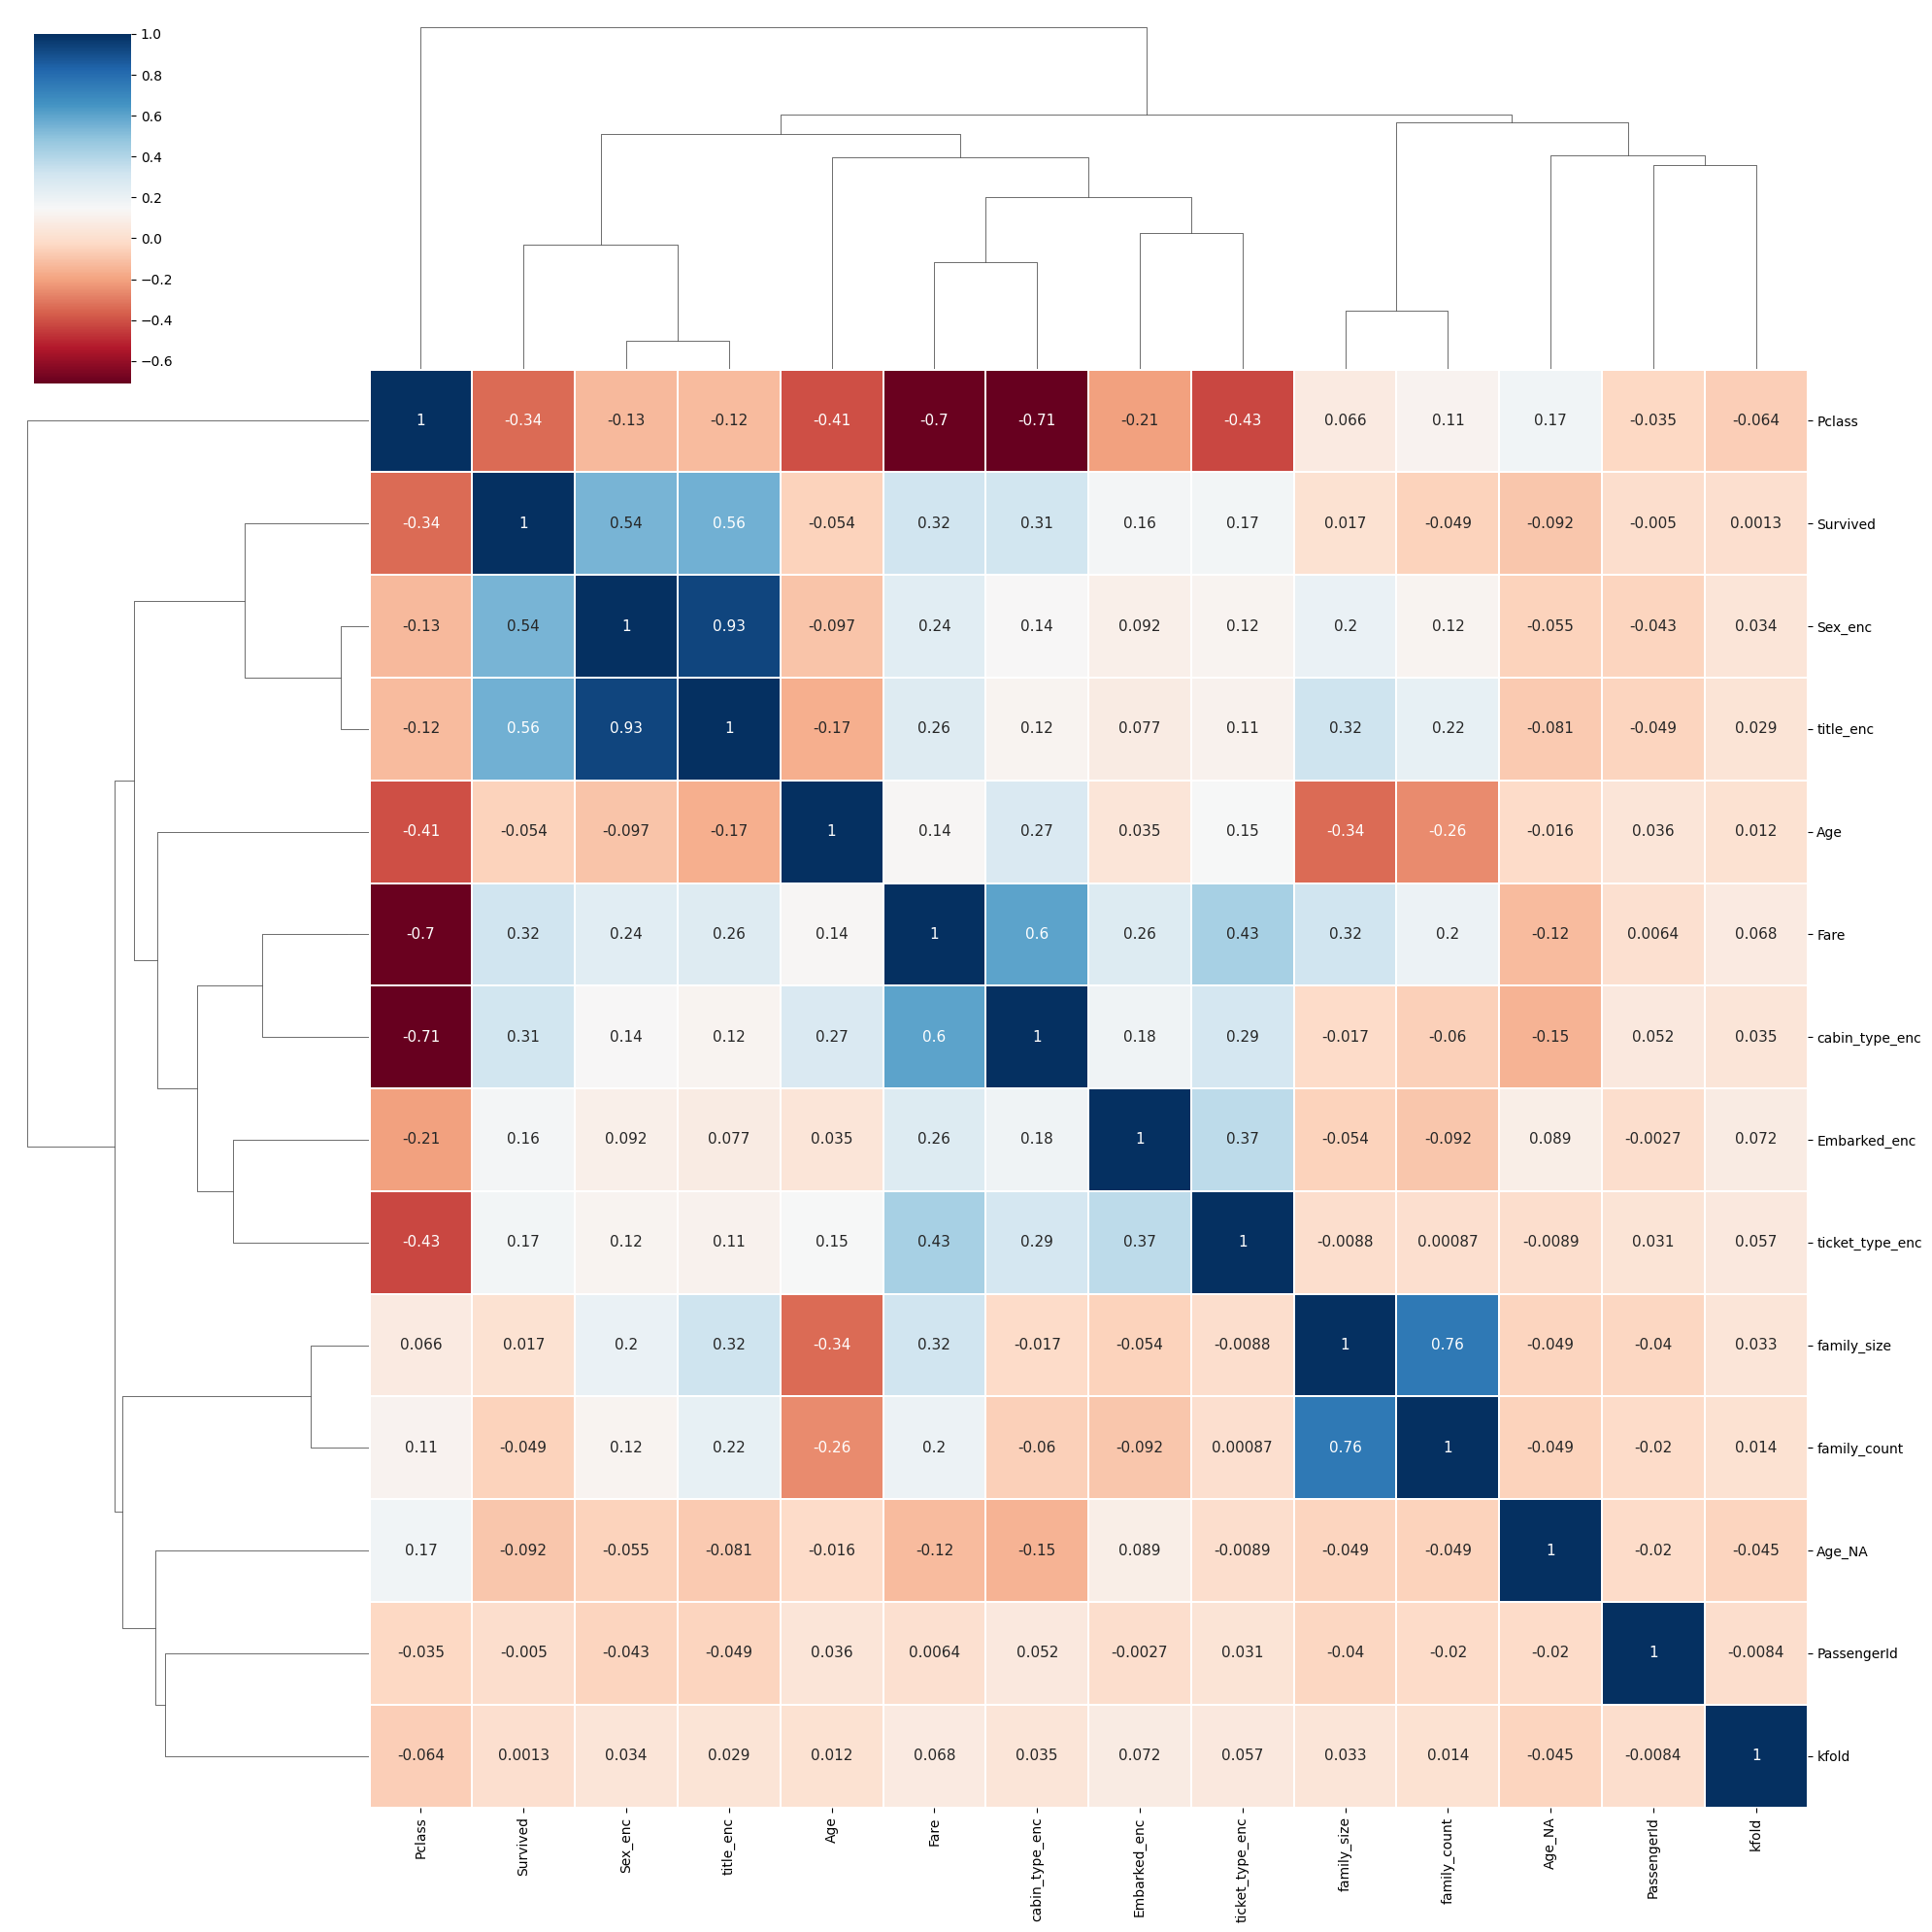

In [60]:
#Visualization of correlation of features
plt.figure(figsize=(18,10))
sns.clustermap(train_mean.corr(), linewidths=0.1, vmax=1.0, 
               square=True, linecolor="white", cmap=colormap, annot=True,
               annot_kws={"size":11}, figsize=(20,20))
plt.show()

**4. Frequency Encoder**

In [61]:
# to study :
"""
#Visualisation
plt.figure(dpi=90)
ax = sns.distplot(train_mean.Survived, kde=False, norm_hist=True)
ax = sns.kdeplot(train_mean.Sex_enc, color='r', ax=ax)
ax.set_xlabel("Sex_enc")
ax.legend(labels=['Survived', 'Sex_enc']);

and 

train = train.merge(train__, left_index=True, right_index=True, how="left")
test = test.merge(test__, left_index=True, right_index=True, how="left")
"""

'\n#Visualisation\nplt.figure(dpi=90)\nax = sns.distplot(train_mean.Survived, kde=False, norm_hist=True)\nax = sns.kdeplot(train_mean.Sex_enc, color=\'r\', ax=ax)\nax.set_xlabel("Sex_enc")\nax.legend(labels=[\'Survived\', \'Sex_enc\']);\n\nand \n\ntrain = train.merge(train__, left_index=True, right_index=True, how="left")\ntest = test.merge(test__, left_index=True, right_index=True, how="left")\n'

In [62]:
train_freq = df.copy()
test_freq = df_test.copy()

In [63]:
freq_col = ['Sex', 'Embarked', 'ticket_type', 'cabin_type', 'title']

In [64]:
final_train_freq = train_freq.copy()
for col in freq_col:
    final_col_freq = pd.Series(index=final_train_freq.index, dtype=float)
    test_col_freq = pd.DataFrame()
    for fold in range(5):
        fold_train = train_freq[train_freq.kfold != fold]
        fold_valid = train_freq[train_freq.kfold == fold]
        #fold_test = test_freq.copy()
        
        fold_freq = fold_train[col].value_counts().to_dict()

        final_col_freq.loc[fold_valid.index] = fold_valid[col].map(fold_freq)
        test_col_freq[f"{col}_enc_{fold}"] = test_freq[col].map(fold_freq)

    #Column maxima
    max_col = train_freq[col].value_counts().max()
    final_col_freq.fillna(max_col, inplace=True)
    final_train_freq[col + "_enc"] = final_col_freq

    test_freq[col + "_enc"] = test_col_freq.mean(axis=1)
    test_freq[col + "_enc"].fillna(max_col, inplace=True)

train_freq = final_train_freq

In [65]:
train_freq = train_freq.drop(freq_col, axis=1)
test_freq = test_freq.drop(freq_col, axis=1)

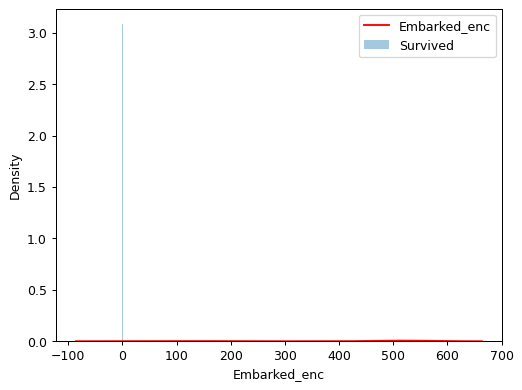

In [66]:
#Visualization
plt.figure(dpi=90)
ax = sns.distplot(train_freq.Survived, kde=False, norm_hist=True)
ax = sns.kdeplot(train_freq.Embarked_enc, color='r', ax=ax)
ax.set_xlabel("Embarked_enc")
ax.legend(labels=["Embarked_enc", "Survived"])
plt.show()

<Figure size 3600x2000 with 0 Axes>

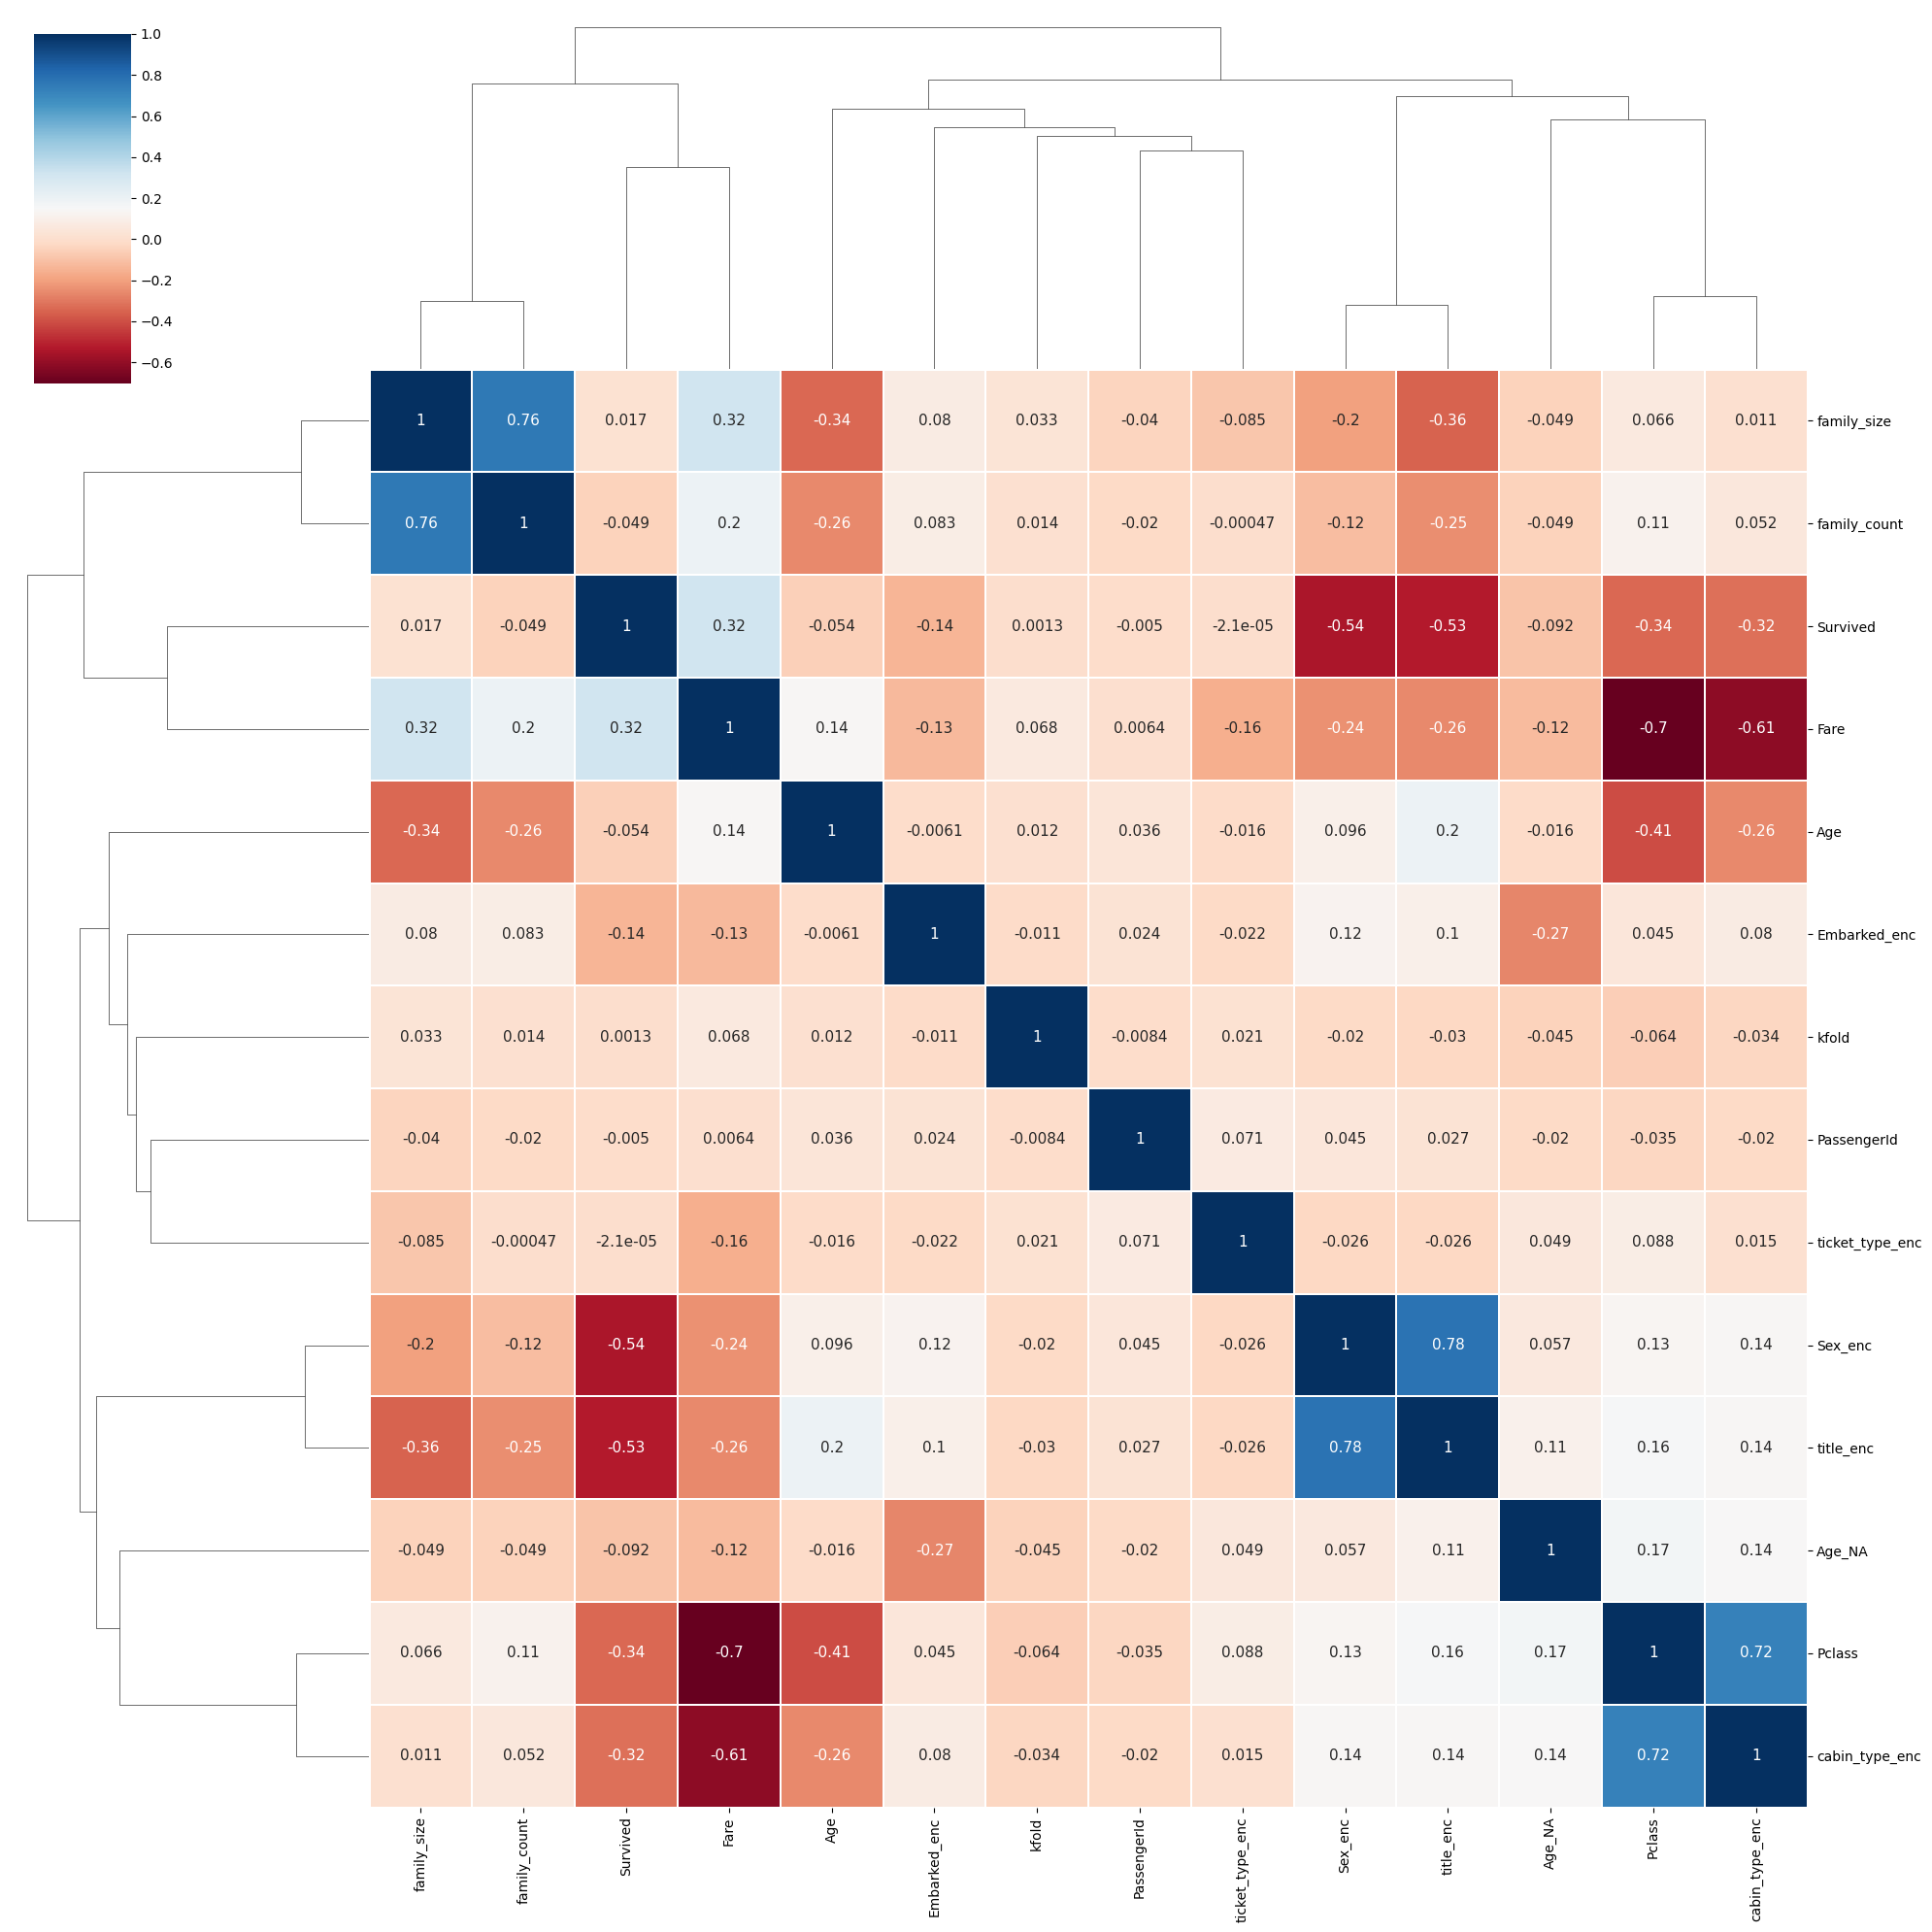

In [67]:
plt.figure(dpi = 200, figsize=(18,10))
sns.clustermap(train_freq.corr(), linewidths=0.1, vmax=1.0,
              square=True, linecolor="white", cmap=colormap, 
              annot=True, annot_kws={"size":11}, figsize=(20,20))
plt.show()

<Axes: xlabel='Sex_enc', ylabel='Survived'>

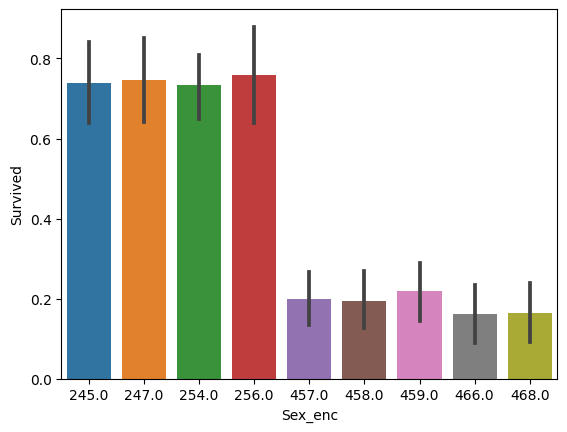

In [68]:
sns.barplot(x='Sex_enc', y='Survived', data=train_freq)

# **Modeling**

In [69]:
def separate(data_train, data_test):
    data_train.columns = data_train.columns.astype(str)
    data_test.columns = data_test.columns.astype(str)
    X = data_train.drop(["Survived"], axis=1)
    y = data_train[["Survived", "kfold"]]
    return X, y, data_test

def useful_col(data):
    u_col = [col for col in data.columns if col not in ["PassengerId", "kfold"]]
    data = data[u_col]
    return data

We will use various classifiers and will compare to see which combinations performed the best.

**1. Random Forest**

In [70]:
def random_forest(X, y):
    max_depths = [2, 4, 5, 10]
    n_estimators_ = [200, 500, 1000, 2000]
    min_samples_splits = [3, 4, 5]
                 
    best_score = -np.inf
    best_params = {}
    #fold_scores = []
    for max_depth in max_depths:
        for n_estimators in n_estimators_:
            for min_samples_split in min_samples_splits:
                scores = []
                for fold in range(5):
                    xtrain = X[X.kfold != fold].reset_index(drop=True)
                    ytrain = y[y.kfold != fold].reset_index(drop=True)
        
                    xvalid = X[X.kfold == fold].reset_index(drop=True)
                    yvalid = y[y.kfold == fold].reset_index(drop=True)
        
                    xtrain = useful_col(xtrain)
                    ytrain = useful_col(ytrain)
        
                    xvalid = useful_col(xvalid)
                    yvalid = useful_col(yvalid)
        
                    model = RandomForestClassifier(random_state=fold, max_depth = max_depth,n_estimators = n_estimators, min_samples_split = min_samples_split, n_jobs=-1)
                    model.fit(xtrain, ytrain)
                    preds = model.predict(xvalid)
                    score = metrics.accuracy_score(yvalid, preds)
                    scores.append(score)

                avg_score = np.mean(scores)
                #fold_scores.append((max_depth, n_estimators, min_samples_split),avg_score)
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = {"max_depth":max_depth, "n_estimators":n_estimators, "min_samples_split":min_samples_split}

    return best_params, best_score

**2. Gradient Boosting**

In [71]:
def gradient_boosting(X, y):
    max_depths = [2, 4, 10, 15]
    n_estimators_ = [10, 50, 100, 200]
    min_samples_splits = [5, 10, 15]
                 
    best_score = -np.inf
    best_params = {}
    for max_depth in max_depths:
        for n_estimators in n_estimators_:
            for min_samples_split in min_samples_splits:
                scores = []
                for fold in range(5):
                    xtrain = X[X.kfold != fold].reset_index(drop=True)
                    ytrain = y[y.kfold != fold].reset_index(drop=True)
        
                    xvalid = X[X.kfold == fold].reset_index(drop=True)
                    yvalid = y[y.kfold == fold].reset_index(drop=True)
        
                    xtrain = useful_col(xtrain)
                    ytrain = useful_col(ytrain)
        
                    xvalid = useful_col(xvalid)
                    yvalid = useful_col(yvalid)
        
                    model = GradientBoostingClassifier(random_state=fold, max_depth = max_depth,n_estimators = n_estimators, min_samples_split = min_samples_split)
                    model.fit(xtrain, ytrain)
                    preds = model.predict(xvalid)
                    score = metrics.accuracy_score(yvalid, preds)
                    scores.append(score)

                avg_score = np.mean(scores)
                #fold_scores.append((max_depth, n_estimators, min_samples_split),avg_score)
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = {"max_depth":max_depth, "n_estimators":n_estimators, "min_samples_split":min_samples_split}

    return best_params, best_score

**3. KNN**

In [72]:
def knn_(X, y):
    kneighborsclassifier__n_neighbors = [2,3,4,5,6,7,8,9,10]
                 
    best_score = -np.inf
    best_params = {}
    for n_neighbor in kneighborsclassifier__n_neighbors:
        scores = []
        for fold in range(5):
            xtrain = X[X.kfold != fold].reset_index(drop=True)
            ytrain = y[y.kfold != fold].reset_index(drop=True)
        
            xvalid = X[X.kfold == fold].reset_index(drop=True)
            yvalid = y[y.kfold == fold].reset_index(drop=True)
        
            xtrain = useful_col(xtrain)
            ytrain = useful_col(ytrain)
        
            xvalid = useful_col(xvalid)
            yvalid = useful_col(yvalid)
        
            model = make_pipeline(preprocessing.MinMaxScaler(), KNeighborsClassifier())
            model.set_params(kneighborsclassifier__n_neighbors = n_neighbor)
            model.fit(xtrain, ytrain)
            preds = model.predict(xvalid)
            score = metrics.accuracy_score(yvalid, preds)
            scores.append(score)
        
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = {'kneighborsclassifier__n_neighbors':n_neighbor}

    return best_params, best_score

**4. SVC**

In [73]:
def svc_(X, y):
    svc__C = [0.0001, 0.001, 0.1, 1, 10, 100]
    svc__gamma = [0.0001, 0.001, 0.1, 1, 10, 50, 100]
    svc__kernel = ['rbf']
    svc__degree = [1,2,3,4]

                 
    best_score = -np.inf
    best_params = {}
    for C in svc__C:
        for gamma in svc__gamma:
            for kernel in svc__kernel:
                for degree in svc__degree:
                    scores = []
                    for fold in range(5):
                        xtrain = X[X.kfold != fold].reset_index(drop=True)
                        ytrain = y[y.kfold != fold].reset_index(drop=True)
                    
                        xvalid = X[X.kfold == fold].reset_index(drop=True)
                        yvalid = y[y.kfold == fold].reset_index(drop=True)
                    
                        xtrain = useful_col(xtrain)
                        ytrain = useful_col(ytrain)
                    
                        xvalid = useful_col(xvalid)
                        yvalid = useful_col(yvalid)
                    
                        model = make_pipeline(preprocessing.StandardScaler(), SVC(random_state = fold))
                        #make_pipeline automatically name the steps using lowercase class names,here svc
                        model.set_params(svc__C = C, svc__gamma = gamma, svc__kernel = kernel, svc__degree = degree)
                        model.fit(xtrain, ytrain)
                        preds = model.predict(xvalid)
                        score = metrics.accuracy_score(yvalid, preds)
                        scores.append(score)
                    
                    avg_score = np.mean(scores)
                    if avg_score > best_score:
                        best_score = avg_score
                        best_params = {'svc__C':C, 'svc__gamma':gamma, 'svc__kernel':kernel, 'svc__degree':degree}
                        
    return best_params, best_score

**5. XG Boost - optimization using optuna**

In [74]:
def optimize(trial, X, y):
    #Hyperparameters
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 200, 2000),
        'max_depth':trial.suggest_int('max_depth', 3, 15),
        'learning_rate':trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'gamma':trial.suggest_float('gamma', 0, 10),
        'subsample':trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha':trial.suggest_float('reg_alpha', 1e-4, 1e2, log=True),
        'reg_lambda':trial.suggest_float('reg_lambda', 1e-4, 1e2, log=True),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 10),
        'use_label_encoder':False,
        #For GPU usage
        'tree_method':'gpu_hist',
        'gpu_id':0,
        'predictor':'gpu_predictor'
    }

    scores = []
    for fold in range(5):
        xtrain = X[X.kfold != fold].reset_index(drop=True)
        ytrain = y[y.kfold != fold].reset_index(drop=True)
    
        xvalid = X[X.kfold == fold].reset_index(drop=True)
        yvalid = y[y.kfold == fold].reset_index(drop=True)
    
        xtrain = useful_col(xtrain)
        ytrain = useful_col(ytrain)
    
        xvalid = useful_col(xvalid)
        yvalid = useful_col(yvalid)

        params['random_state'] = fold
        model = XGBClassifier(**params)
        model.fit(xtrain, ytrain)
        preds = model.predict(xvalid)
        score = metrics.accuracy_score(yvalid, preds)
        scores.append(score)
    return np.mean(scores)

def tune_xgb_with_optuna(X, y, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial : optimize(trial, X, y), n_trials = n_trials)
    return study.best_params, study.best_value

In [75]:
def final_test_preds(X, y, X_test, model):
    final_preds = []
    test_col = [col for col in X_test.columns if col not in ["PassengerId"]]
    for fold in range(5):
        xtrain = X[X.kfold != fold].reset_index(drop=True)
        ytrain = y[y.kfold != fold].reset_index(drop=True)

        xtrain = useful_col(xtrain)
        ytrain = useful_col(ytrain)
        xtest = X_test.copy()
        xtest = xtest[test_col]
        

        model.fit(xtrain, ytrain)
        test_preds = model.predict(xtest)
        final_preds.append(test_preds)

    test_predictions = np.mean(np.column_stack(final_preds), axis=1)
    return test_predictions

In [76]:
def submission_(preds, sample_data):
    sample_data.Survived = preds
    sample_data.to_csv("submission.csv", index=False)
    print("Test predictions submitted successfully")

In [77]:
#Different datasets corresponding to different encodings.
X_onehot, y_onehot, test_onehot_ = separate(train_onehot, test_onehot)
X_label, y_label, test_label_ = separate(train_label, test_label)
X_mean, y_mean, test_mean_ = separate(train_mean, test_mean)
X_freq, y_freq, test_freq_ = separate(train_freq, test_freq)

**1. Hyperparameter evaluation for Random Forest**

In [78]:
"""
#Random Forest
best_params_RF_onehot, best_score_RF_onehot = random_forest(X_onehot, y_onehot)
best_params_RF_label, best_score_RF_label = random_forest(X_label, y_label)
best_params_RF_mean, best_score_RF_mean = random_forest(X_mean, y_mean)
best_params_RF_freq, best_score_RF_freq = random_forest(X_freq, y_freq)

print(best_params_RF_onehot, best_score_RF_onehot)
print(best_params_RF_label, best_score_RF_label)
print(best_params_RF_mean, best_score_RF_mean)
print(best_params_RF_freq, best_score_RF_freq)
"""

'\n#Random Forest\nbest_params_RF_onehot, best_score_RF_onehot = random_forest(X_onehot, y_onehot)\nbest_params_RF_label, best_score_RF_label = random_forest(X_label, y_label)\nbest_params_RF_mean, best_score_RF_mean = random_forest(X_mean, y_mean)\nbest_params_RF_freq, best_score_RF_freq = random_forest(X_freq, y_freq)\n\nprint(best_params_RF_onehot, best_score_RF_onehot)\nprint(best_params_RF_label, best_score_RF_label)\nprint(best_params_RF_mean, best_score_RF_mean)\nprint(best_params_RF_freq, best_score_RF_freq)\n'

Obtained results for Random Forest are:

For One-Hot Encoding:
{'max_depth': 5, 'n_estimators': 1000, 'min_samples_split': 4} 
0.8282719226664993

For Label Encoding:
{'max_depth': 5, 'n_estimators': 1000, 'min_samples_split': 4}
0.8260435628648548

For Mean-Target Encoding:
{'max_depth': 10, 'n_estimators': 500, 'min_samples_split': 3} 
0.8249325214989642

For Frequency Encoding:
{'max_depth': 4, 'n_estimators': 1000, 'min_samples_split': 4}
0.8327474734793798

**a.) For Onehot encoding+Random Forest**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> increase the n_estimators and decrease max_depth than that obtained above.

In [79]:
"""
best_params_submit = {'max_depth': 5, 'n_estimators': 5000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}
classifier_ = RandomForestClassifier(**best_params_submit)
submission_(final_test_preds(X_onehot, y_onehot, test_onehot_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'max_depth': 5, 'n_estimators': 5000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}\nclassifier_ = RandomForestClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_onehot, y_onehot, test_onehot_, classifier_).astype(int), submission)\n"

So, on increasing the n_estimators only, the scores improved on public leaderboard, suggesting that earlier our model was overfitting. Hence, optimal hyperparameter for onehot encoded dataset are:-

{'max_depth': 5, 'n_estimators': 5000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}
0.79186

**b.) For Label encoding+Random Forest**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> increase the n_estimators and/or decrease max_depth and/or increase min_samples_split than that obtained above.

In [80]:
"""
best_params_submit = {'max_depth': 2, 'n_estimators': 1000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}
classifier_ = RandomForestClassifier(**best_params_submit)
submission_(final_test_preds(X_label, y_label, test_label_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'max_depth': 2, 'n_estimators': 1000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}\nclassifier_ = RandomForestClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_label, y_label, test_label_, classifier_).astype(int), submission)\n"

So, on decreasing max_depth and decreasing n_estimators, the scores improved on public leaderboard, suggesting that earlier our model was overfitting and learning a lot of noise. Hence, optimal hyperparameter for label encoded dataset are:-

{'max_depth': 2, 'n_estimators': 1000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}
0.78708

**c.) For Mean-Target encoding+Random Forest**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> increase the n_estimators and/or decrease max_depth and/or increase min_samples_split than that obtained above.

In [81]:
"""
best_params_submit = {'max_depth': 10, 'n_estimators': 500, 'min_samples_split': 3, 'random_state':66, 'n_jobs':-1}
classifier_ = RandomForestClassifier(**best_params_submit)
submission_(final_test_preds(X_mean, y_mean, test_mean_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'max_depth': 10, 'n_estimators': 500, 'min_samples_split': 3, 'random_state':66, 'n_jobs':-1}\nclassifier_ = RandomForestClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_mean, y_mean, test_mean_, classifier_).astype(int), submission)\n"

There is further decrease in scores on public leaderboard on increasing n_estimators and/or decreasing max_depth and/or increasing min_samples_split, so our model is neither overfitting nor underfitting. Hence, optimal hyperparameter for mean-target encoded dataset are:-

{'max_depth': 10, 'n_estimators': 500, 'min_samples_split': 3, 'random_state':66, 'n_jobs':-1}
0.78947

**d.) For Frequency encoding+Random Forest**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> increase the n_estimators and/or decrease max_depth and/or increase min_samples_split than that obtained above.

In [82]:
"""
best_params_submit = {'max_depth': 4, 'n_estimators': 2000, 'min_samples_split': 6, 'random_state':66, 'n_jobs':-1}
classifier_ = RandomForestClassifier(**best_params_submit)
submission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'max_depth': 4, 'n_estimators': 2000, 'min_samples_split': 6, 'random_state':66, 'n_jobs':-1}\nclassifier_ = RandomForestClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)\n"

So, on increasing n_estimators, the scores improved on public leaderboard, suggesting that earlier our model was overfitting and learning a lot of noise. Hence, optimal hyperparameter for frequency encoded dataset are:-

{'max_depth': 4, 'n_estimators': 2000, 'min_samples_split': 6, 'random_state':66, 'n_jobs':-1}
0.79425

**Best performing pair:**

**1. Frequency Encoding + Random Forest - 0.79425**

{'max_depth': 4, 'n_estimators': 2000, 'min_samples_split': 6, 'random_state':66, 'n_jobs':-1}


**2. OneHot Encoding + Random Forest - 0.79186** 

{'max_depth': 5, 'n_estimators': 5000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}

**2. Hyperparameter evaluation for Gradient Boosting**

In [83]:
"""
#Gradient Boosting
best_params_GB_onehot, best_score_GB_onehot = gradient_boosting(X_onehot, y_onehot)
best_params_GB_label, best_score_GB_label = gradient_boosting(X_label, y_label)
best_params_GB_mean, best_score_GB_mean = gradient_boosting(X_mean, y_mean)
best_params_GB_freq, best_score_GB_freq = gradient_boosting(X_freq, y_freq)

print(best_params_GB_onehot, best_score_GB_onehot)
print(best_params_GB_label, best_score_GB_label)
print(best_params_GB_mean, best_score_GB_mean)
print(best_params_GB_freq, best_score_GB_freq)
"""

'\n#Gradient Boosting\nbest_params_GB_onehot, best_score_GB_onehot = gradient_boosting(X_onehot, y_onehot)\nbest_params_GB_label, best_score_GB_label = gradient_boosting(X_label, y_label)\nbest_params_GB_mean, best_score_GB_mean = gradient_boosting(X_mean, y_mean)\nbest_params_GB_freq, best_score_GB_freq = gradient_boosting(X_freq, y_freq)\n\nprint(best_params_GB_onehot, best_score_GB_onehot)\nprint(best_params_GB_label, best_score_GB_label)\nprint(best_params_GB_mean, best_score_GB_mean)\nprint(best_params_GB_freq, best_score_GB_freq)\n'

Obtained results for Gradient Boosting are:

For One-Hot Encoding:
{'max_depth':2, 'n_estimators':100, 'min_samples_split':15} 
0.8238214801330738

For Label Encoding:
{'max_depth':2, 'n_estimators':50, 'min_samples_split':5}
0.8249262444291003

For Mean-Target Encoding:
{'max_depth':4, 'n_estimators':100, 'min_samples_split':15} 
0.8282907538760907

For Frequency Encoding:
{'max_depth':4, 'n_estimators':200, 'min_samples_split':15}
0.8294143493817087

**Since, best two performing encodings are Mean-Target Encoding and Frequency Encoding, so lets consider their analysis on public leaderboard:-**

**a.) For Mean-Target encoding+Gradient Boosting**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> decrease the n_estimators and/or decrease max_depth than that obtained above.

In [84]:
"""
best_params_submit = {'max_depth': 4, 'n_estimators': 100, 'min_samples_split': 15, 'random_state':33}
classifier_ = GradientBoostingClassifier(**best_params_submit)
submission_(final_test_preds(X_mean, y_mean, test_mean_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'max_depth': 4, 'n_estimators': 100, 'min_samples_split': 15, 'random_state':33}\nclassifier_ = GradientBoostingClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_mean, y_mean, test_mean_, classifier_).astype(int), submission)\n"

There is further decrease in scores on public leaderboard on increasing n_estimators and/or decreasing max_depth and/or increasing min_samples_split, so our model is neither overfitting nor underfitting. Hence, optimal hyperparameter for mean-target encoded dataset are:-

{'max_depth': 4, 'n_estimators': 100, 'min_samples_split': 15, 'random_state':33}
0.78229

**b.) For Frequency encoding+Gradient Boosting**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> decrease the n_estimators and/or decrease max_depth than that obtained above.

In [85]:
"""
best_params_submit = {'max_depth': 4, 'n_estimators': 200, 'min_samples_split': 15, 'random_state':33}
classifier_ = GradientBoostingClassifier(**best_params_submit)
submission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'max_depth': 4, 'n_estimators': 200, 'min_samples_split': 15, 'random_state':33}\nclassifier_ = GradientBoostingClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)\n"

There is further decrease in scores on public leaderboard on increasing n_estimators and/or decreasing max_depth and/or increasing min_samples_split, so our model is neither overfitting nor underfitting. Hence, optimal hyperparameter for frequency encoded dataset are:-

{'max_depth': 4, 'n_estimators': 200, 'min_samples_split': 15, 'random_state':33}
0.78229

**Best performance score on public leaderboard and corresponding hyperparameters:**

**1. Mean-Target Encoding + Gradient Boosting - 0.78229**

{'max_depth': 4, 'n_estimators': 100, 'min_samples_split': 15, 'random_state':33}

**2. Frequency Encoding + Gradient Boosting - 0.78229**

{'max_depth': 4, 'n_estimators': 200, 'min_samples_split': 15, 'random_state':33}

**3. Hyperparameter evaluation for K-Neighbors Classification**

In [86]:
"""
#KNeighborsClassification
best_params_KNN_onehot, best_score_KNN_onehot = knn_(X_onehot, y_onehot)
best_params_KNN_label, best_score_KNN_label = knn_(X_label, y_label)
best_params_KNN_mean, best_score_KNN_mean = knn_(X_mean, y_mean)
best_params_KNN_freq, best_score_KNN_freq = knn_(X_freq, y_freq)

print(best_params_KNN_onehot, best_score_KNN_onehot)
print(best_params_KNN_label, best_score_KNN_label)
print(best_params_KNN_mean, best_score_KNN_mean)
print(best_params_KNN_freq, best_score_KNN_freq)
"""

'\n#KNeighborsClassification\nbest_params_KNN_onehot, best_score_KNN_onehot = knn_(X_onehot, y_onehot)\nbest_params_KNN_label, best_score_KNN_label = knn_(X_label, y_label)\nbest_params_KNN_mean, best_score_KNN_mean = knn_(X_mean, y_mean)\nbest_params_KNN_freq, best_score_KNN_freq = knn_(X_freq, y_freq)\n\nprint(best_params_KNN_onehot, best_score_KNN_onehot)\nprint(best_params_KNN_label, best_score_KNN_label)\nprint(best_params_KNN_mean, best_score_KNN_mean)\nprint(best_params_KNN_freq, best_score_KNN_freq)\n'

Obtained results for KNeighbors are:

For One-Hot Encoding:
{'kneighborsclassifier__n_neighbors':9} 
0.8080911430544223

For Label Encoding:
{'kneighborsclassifier__n_neighbors':9}
0.8125792480070304

For Mean-Target Encoding:
{'kneighborsclassifier__n_neighbors':9} 
0.8137091205825122

For Frequency Encoding:
{'kneighborsclassifier__n_neighbors':7}
0.8114744837110038

**Since, best two performing encodings are Label Encoding and Mean-Target Encoding, so lets consider their analysis on public leaderboard:-**

**a.) For Label encoding+K-Neighbors Classification**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better->

Increase the n_neighbors (as low n_neighbors reduces variance and KNN memorizes the noise in the data leading to overfitting), add weights = 'distance'(it gives closer neighbors more weight and focuses on nearer points while weights = 'uniform' leads to overfitting) or can add metric parameter (by default is 'minkowski', so try p=1 for Manhattan (metric = 'manhattan') or cosine or euclidean)  [optional]

Note that--->  Make sure scaling is done inside the pipeline and not done before splitting or using CV splits as otherwise there will be data leakage..... Also, use stratified K-Fold to avoid leakage and match target distribution

In [87]:
"""
classifier_ = make_pipeline(preprocessing.MinMaxScaler(), KNeighborsClassifier(n_neighbors = 9, metric='manhattan'))
submission_(final_test_preds(X_label, y_label, test_label_, classifier_).astype(int), submission)
"""

"\nclassifier_ = make_pipeline(preprocessing.MinMaxScaler(), KNeighborsClassifier(n_neighbors = 9, metric='manhattan'))\nsubmission_(final_test_preds(X_label, y_label, test_label_, classifier_).astype(int), submission)\n"

So, on changing metric from minkowski to manhattan, scores improved. The reasons for this can be:-

1. When features are not heavily correlated and important features are not interactions but individual dimensions, then manhattan is better.
2. Minkowski uses euclidean norm or L2 norm (square root of sum of squares of differences) and manhattan uses L1 norm (sum of absolute difference), so manhattan is less sensitive to outliers and noise and donot blow of large differences as much as minkowski.

Note---> Minkowski is actually 1/pth power of sum of difference raised to power to p, and for p=1, it is manhattan and for p=2, it is euclidean and by default, p=2 is used, so in above points, minkowski refers to p=2 (Euclidean).


Hence, optimal hyperparameter for label encoded dataset are:-

{n_neighbors = 9, metric='manhattan'}
0.79186

**b.) For Mean-Target encoding+K-Neighbors Classification**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better->

Increase the n_neighbors (as low n_neighbors reduces variance and KNN memorizes the noise in the data leading to overfitting), add weights = 'distance'(it gives closer neighbors more weight and focuses on nearer points while weights = 'uniform' leads to overfitting) or can add metric parameter (by default is 'minkowski', so try p=1 for Manhattan (metric = 'manhattan') or cosine or euclidean)[optional]

Note----> Mahalanobis distance can be used if features are not independently informative and correlated as it accounts for features correlation (metric='mahalanobis', metric_params={'V': np.cov(X_train.T)}---> see pdf for codes, compute covariance matrix inside folds of min-max scaled X_train data inside final_test_preds function defined above)

Note that--->  Make sure scaling is done inside the pipeline and not done before splitting or using CV splits as otherwise there will be data leakage..... Also, use stratified K-Fold to avoid leakage and match target distribution

In [88]:
"""
classifier_ = make_pipeline(preprocessing.MinMaxScaler(), KNeighborsClassifier(n_neighbors = 9, metric='euclidean'))
submission_(final_test_preds(X_mean, y_mean, test_mean_, classifier_).astype(int), submission)
"""

"\nclassifier_ = make_pipeline(preprocessing.MinMaxScaler(), KNeighborsClassifier(n_neighbors = 9, metric='euclidean'))\nsubmission_(final_test_preds(X_mean, y_mean, test_mean_, classifier_).astype(int), submission)\n"

So, on applying above suggestions scores decreased on public leaderboard, also, here on changing to manhattan metric scores decreased because it mean-target encoded data and hence features are well-scaled, dense (not sparse and axis-aligned,i.e.,each feature is independently informative and not much correlated, as in manhattan case) and interact in a correlated and continuous way. Also, geometry of the data is round,i.e.,points clusters in a spherical way (and not dense on some axis and not all axes, as in manahattan case that uses square-like neighborhoods), so data benefits from capturing diagonal/interaction distances which euclidean does best. 

Hence, optimal hyperparameter for mean-target encoded dataset are:-

{n_neighbors = 9, metric='euclidean'}
0.78708

**Best performance score on public leaderboard and corresponding hyperparameters:**

**1. Label Encoding + K-Neighbors Classification - 0.79186**

{n_neighbors = 9, metric='manhattan'}



**2. Mean-Target Encoding + K-Neighbors Classification - 0.78708**

{n_neighbors = 9, metric='euclidean'}

**4. Hyperparameter evaluation for C-Support Vector Classification (SVC)**

In [89]:
"""
#C-Support Vector Classification (SVC)
best_params_SVC_onehot, best_score_SVC_onehot = svc_(X_onehot, y_onehot)
best_params_SVC_label, best_score_SVC_label = svc_(X_label, y_label)
best_params_SVC_mean, best_score_SVC_mean = svc_(X_mean, y_mean)
best_params_SVC_freq, best_score_SVC_freq = svc_(X_freq, y_freq)

print(best_params_SVC_onehot, best_score_SVC_onehot)
print(best_params_SVC_label, best_score_SVC_label)
print(best_params_SVC_mean, best_score_SVC_mean)
print(best_params_SVC_freq, best_score_SVC_freq)
"""

'\n#C-Support Vector Classification (SVC)\nbest_params_SVC_onehot, best_score_SVC_onehot = svc_(X_onehot, y_onehot)\nbest_params_SVC_label, best_score_SVC_label = svc_(X_label, y_label)\nbest_params_SVC_mean, best_score_SVC_mean = svc_(X_mean, y_mean)\nbest_params_SVC_freq, best_score_SVC_freq = svc_(X_freq, y_freq)\n\nprint(best_params_SVC_onehot, best_score_SVC_onehot)\nprint(best_params_SVC_label, best_score_SVC_label)\nprint(best_params_SVC_mean, best_score_SVC_mean)\nprint(best_params_SVC_freq, best_score_SVC_freq)\n'

Obtained results for C-Support Vector Classification (SVC) are:

For One-Hot Encoding:
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf', 'svc__degree': 1} 0.8271357730211537

For Label Encoding:
{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__degree': 1} 0.8237838177138912

For Mean-Target Encoding:
{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__degree': 1} 0.8238152030632101

For Frequency Encoding:
{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__degree': 1} 0.8248948590797814

**Since, best two performing encodings are OneHot Encoding and Frequency Encoding, so lets consider their analysis on public leaderboard:-**

**a.) For Onehot encoding+C-Support Vector Classification (SVC)**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better->

Decrease C value (as high C value will make model very strict and will heavily penalize misclassifications of target value. It will reduces bias but increase variance, i.e., model fits training data well but may overfit and generalize poorly on new data, make C = 10 or 1 or 0.1) and slightly increase gamma(as low gamma means each point will have wide influence and decision boundary will be simpler and smooth and general like straight lines or gently curves and kernel become too smooth, that is, it is like using a broad marker trying to make a clear boundary to distinguish between points, but using high gamma (0.01, 0.1, 1, 10) is like using fine tip pen to draw boundary and it will make more wiggly lines to clearly separate data points)

In [90]:
"""
best_params_submit = {'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'random_state':99}
classifier_ = make_pipeline(preprocessing.StandardScaler(), SVC(**best_params_submit))
submission_(final_test_preds(X_onehot, y_onehot, test_onehot_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'random_state':99}\nclassifier_ = make_pipeline(preprocessing.StandardScaler(), SVC(**best_params_submit))\nsubmission_(final_test_preds(X_onehot, y_onehot, test_onehot_, classifier_).astype(int), submission)\n"

So, on applying above suggested changes, scores didn't improved, hence our model was neither overfitting nor underfitting. Hence, optimal hyperparameter for onehot encoded dataset are:-

Note->  'degree' is irrelevant for rbf kernel so can remove it

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'random_state':99}
0.79425

**b.) For Frequency encoding+C-Support Vector Classification (SVC)**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be underfitting here. So, to improve score->

Increase C value to (1 or 10, as low C value here is forcing model to keep its' boundaries more genarlized and smooth but high gamma value is trying to model complex decision boundaries. So, model is unable to learn fine-graded pattern due to low C value even though gamma wants to introduce complexity, so reduce gamma value as well) and decrease gamma value (to 0.01)

In [91]:
"""
best_params_submit = {'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'degree':1, 'random_state':99}
classifier_ = make_pipeline(preprocessing.StandardScaler(), SVC(**best_params_submit))
submission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'degree':1, 'random_state':99}\nclassifier_ = make_pipeline(preprocessing.StandardScaler(), SVC(**best_params_submit))\nsubmission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)\n"

So, on following above suggestions, scores improved a little, hence our model was underfitting earlier. Hence, optimal hyperparameter for label encoded dataset are:-

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'degree':1, 'random_state':99}
0.78708

**Best performance score on public leaderboard and corresponding hyperparameters:**

**1. OneHot Encoding + C-Support Vector Classification (SVC) - 0.79425**

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'random_state':99}


**2. Frequency Encoding + C-Support Vector Classification (SVC) - 0.78708** 

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'degree':1, 'random_state':99}

**5. Hyperparameter evaluation for XG Boost**

In [92]:
"""
#XG Boost
best_params_xgb_onehot, best_score_xgb_onehot = tune_xgb_with_optuna(X_onehot, y_onehot)
best_params_xgb_label, best_score_xgb_label = tune_xgb_with_optuna(X_label, y_label)
best_params_xgb_mean, best_score_xgb_mean = tune_xgb_with_optuna(X_mean, y_mean)
best_params_xgb_freq, best_score_xgb_freq = tune_xgb_with_optuna(X_freq, y_freq)

print(best_params_xgb_onehot, best_score_xgb_onehot)
print(best_params_xgb_label, best_score_xgb_label)
print(best_params_xgb_mean, best_score_xgb_mean)
print(best_params_xgb_freq, best_score_xgb_freq)
"""

'\n#XG Boost\nbest_params_xgb_onehot, best_score_xgb_onehot = tune_xgb_with_optuna(X_onehot, y_onehot)\nbest_params_xgb_label, best_score_xgb_label = tune_xgb_with_optuna(X_label, y_label)\nbest_params_xgb_mean, best_score_xgb_mean = tune_xgb_with_optuna(X_mean, y_mean)\nbest_params_xgb_freq, best_score_xgb_freq = tune_xgb_with_optuna(X_freq, y_freq)\n\nprint(best_params_xgb_onehot, best_score_xgb_onehot)\nprint(best_params_xgb_label, best_score_xgb_label)\nprint(best_params_xgb_mean, best_score_xgb_mean)\nprint(best_params_xgb_freq, best_score_xgb_freq)\n'

Obtained results for XG Boost are:


For One-Hot Encoding:
{'n_estimators': 1261, 'max_depth': 11, 'learning_rate': 0.01502694166969438, 'gamma': 9.037961341422632, 'subsample': 0.6728742852670258, 'colsample_bytree': 0.48584617429304333, 'reg_alpha': 0.002376632423872071, 'reg_lambda': 0.004831633032654805, 'min_child_weight': 1} 
0.8260184545853996


For Label Encoding:
{'n_estimators': 1443, 'max_depth': 8, 'learning_rate': 0.016556600838569673, 'gamma': 0.512585353321234, 'subsample': 0.648290045450705, 'colsample_bytree': 0.31127383740036646, 'reg_alpha': 0.022140093202344373, 'reg_lambda': 0.00038423625575309637, 'min_child_weight': 2}
0.8327851358985626


For Mean-Target Encoding:
{'n_estimators': 981, 'max_depth': 10, 'learning_rate': 0.09818177488500371, 'gamma': 1.4293282223190467, 'subsample': 0.6455678364878246, 'colsample_bytree': 0.39346474164862716, 'reg_alpha': 0.049651947874937354, 'reg_lambda': 0.03155380074144897, 'min_child_weight': 1} 
0.8283346933651371


For Frequency Encoding:
{'n_estimators': 360, 'max_depth': 11, 'learning_rate': 0.0072121973917407545, 'gamma': 0.6642333248739365, 'subsample': 0.7132670811064601, 'colsample_bytree': 0.837217797998194, 'reg_alpha': 0.00024240025111562125, 'reg_lambda': 0.0006892549943360753, 'min_child_weight': 1} 
0.8339338396836358

**Since, best two performing encodings are Label Encoding and Frequency Encoding, so lets consider their analysis on public leaderboard:-**

**a.) For Label encoding+XG Boost**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> 


Reduce complexity: 

Lower max_depth(as deeper trees increase variance so can overfit, 4-6) and n_estimators(as its high value along with low learning rate can overfit, 1000-2000) while increasing gamma(higher gamma prevents complex splits and help regularize, 1-5), reg_alpha(L1, increases it pushes weight to zero, i.e., feature sparsity, 0.1-1), reg_lambda(L2, increase to regularize more, i.e., penalize large weight, 1-5), and min_child_weight(increasing it will prevent model from learning from small noisy partitions, 5-10).

Increase randomness: 

Use higher colsample_bytree(0.5-0.9) and/or subsample(0.6-0.9) to help avoid reliance on specific features or data rows. subsample introduces row-level randomness,say,subsample=0.8 means each tree will use 80% of training data selected randomly while colsample_bytree introduces feature-level randomness among trees in the ensemble.

Enable early stopping:


In training: use early_stopping_rounds=100 during .fit() with a validation set.
Use stratified K-Fold to maintain class balance in folds if you're not already.

In [93]:
"""
best_params_submit =  {'n_estimators': 2000, 
                       'max_depth': 5, 
                       'learning_rate': 0.016556600838569673, 
                       'gamma': 1.512585353321234, 
                       'subsample': 0.648290045450705, 
                       'colsample_bytree': 0.71127383740036646, 
                       'reg_alpha': 0.522140093202344373, 
                       'reg_lambda': 4.00038423625575309637, 
                       'min_child_weight': 6,
                       'tree_method':'gpu_hist', 
                       'gpu_id':0, 
                       'predictor':'gpu_predictor',
                       'random_state':11
                      }
classifier_ = XGBClassifier(**best_params_submit)
submission_(final_test_preds(X_label, y_label, test_label_, classifier_).astype(int), submission)
"""

"\nbest_params_submit =  {'n_estimators': 2000, \n                       'max_depth': 5, \n                       'learning_rate': 0.016556600838569673, \n                       'gamma': 1.512585353321234, \n                       'subsample': 0.648290045450705, \n                       'colsample_bytree': 0.71127383740036646, \n                       'reg_alpha': 0.522140093202344373, \n                       'reg_lambda': 4.00038423625575309637, \n                       'min_child_weight': 6,\n                       'tree_method':'gpu_hist', \n                       'gpu_id':0, \n                       'predictor':'gpu_predictor',\n                       'random_state':11\n                      }\nclassifier_ = XGBClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_label, y_label, test_label_, classifier_).astype(int), submission)\n"

So, on applying the said changes, scores improved greatly, however, on increasing further the following parameters, gamma or reg_alpha or reg_lambda or min_child_weight or colsample_bytree, scores decreased again, suggesting too much increase in regularization hence making the model more constraint, like by:-

- increasing gamma more, model could not split further, as gamma's main aim is to stop those splits that don't improve the score much
- increasing colsample_bytree heavily doesnot give room for randomness among important and non-important features as mostly all important ones will be selected by all trees, while decreasing it heavily will ignore important features
- increasing reg_alpha more will put more feature weights to zero and/or increasing reg_lambda more will contrain the weight too much for features.

Hence, optimal hyperparameter for label encoded dataset are:-

{'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.016556600838569673, 'gamma': 1.512585353321234, 'subsample': 0.648290045450705, 'colsample_bytree': 0.71127383740036646, 'reg_alpha': 0.522140093202344373, 'reg_lambda': 4.00038423625575309637, 'min_child_weight': 6, 'tree_method':'gpu_hist', 'gpu_id':0, 'predictor':'gpu_predictor','random_state':11}  0.78947

**b.) For Frequency encoding+XG Boost**

On submitting, it is observed that the cross validation scores are higher than that obtained on public leaderboard, so the model might be overfitting here. So, to generalize better-> 


Reduce complexity: 

Lower max_depth(as deeper trees increase variance so can overfit, 6-8) and n_estimators(as its high value along with low learning rate can overfit, 800-1000) while increasing gamma(higher gamma prevents complex splits and help regularize and generalize more, 1-5), reg_alpha(L1, increases it pushes weight to zero, i.e., feature sparsity, 0.1-1), reg_lambda(L2, increase to regularize more, i.e., penalize large weight, 1-10), and min_child_weight(increasing it will prevent model from learning from small noisy partitions, i.e., 3-5).

Increase randomness: 

Colsample_bytree(0.5-0.9) and/or subsample(0.6-0.9) help avoid reliance on specific features or data rows. subsample introduces row-level randomness,say,subsample=0.8 means each tree will use 80% of training data selected randomly while colsample_bytree introduces feature-level randomness among trees in the ensemble.

Note that to prevent overfitting, increase noise slightly/increase randomness slightly but don't learn from them deeply

Enable early stopping:


In training: use early_stopping_rounds=100 during .fit() with a validation set.
Use stratified K-Fold to maintain class balance in folds if you're not already.

In [94]:
"""
best_params_submit = {'n_estimators': 360, 
                      'max_depth': 6, 
                      'learning_rate': 0.0072121973917407545, 
                      'gamma': 0.6642333248739365, 
                      'subsample': 0.7132670811064601, 
                      'colsample_bytree': 0.837217797998194, 
                      'reg_alpha': 0.4, 
                      'reg_lambda': 4, 
                      'min_child_weight': 3,
                      'tree_method':'gpu_hist', 
                      'gpu_id':0, 
                      'predictor':'gpu_predictor',
                      'random_state':11
                     }
classifier_ = XGBClassifier(**best_params_submit)
submission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)
"""

"\nbest_params_submit = {'n_estimators': 360, \n                      'max_depth': 6, \n                      'learning_rate': 0.0072121973917407545, \n                      'gamma': 0.6642333248739365, \n                      'subsample': 0.7132670811064601, \n                      'colsample_bytree': 0.837217797998194, \n                      'reg_alpha': 0.4, \n                      'reg_lambda': 4, \n                      'min_child_weight': 3,\n                      'tree_method':'gpu_hist', \n                      'gpu_id':0, \n                      'predictor':'gpu_predictor',\n                      'random_state':11\n                     }\nclassifier_ = XGBClassifier(**best_params_submit)\nsubmission_(final_test_preds(X_freq, y_freq, test_freq_, classifier_).astype(int), submission)\n"

So, on applying the said changes, scores improved greatly, however, on increasing further the following parameters, gamma or reg_alpha or reg_lambda or min_child_weight or colsample_bytree, scores decreased again, suggesting too much increase in regularization hence making the model more constraint, like by:-

- increasing gamma more, model could not split further, as gamma's main aim is to stop those splits that don't improve the score much
- increasing colsample_bytree heavily doesnot give room for randomness among important and non-important features as mostly all important ones will be selected by all trees, while decreasing it heavily will ignore important features
- increasing reg_alpha more will put more feature weights to zero and/or increasing reg_lambda more will contrain the weight too much for features.

Hence, optimal hyperparameter for label encoded dataset are:-

{'n_estimators': 360, 'max_depth': 6, 'learning_rate': 0.0072121973917407545, 'gamma': 0.6642333248739365, 'subsample': 0.7132670811064601, 'colsample_bytree': 0.837217797998194, 'reg_alpha': 0.4, 'reg_lambda': 4, 'min_child_weight': 3, 'tree_method':'gpu_hist', 'gpu_id':0, 'predictor':'gpu_predictor', 'random_state':11}  0.80143

**Best performance score on public leaderboard and corresponding hyperparameters:**

**1. Label Encoding + XG Boost - 0.78947**

{'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.016556600838569673, 'gamma': 1.512585353321234, 'subsample': 0.648290045450705, 'colsample_bytree': 0.71127383740036646, 'reg_alpha': 0.522140093202344373, 'reg_lambda': 4.00038423625575309637, 'min_child_weight': 6, 'tree_method':'gpu_hist', 'gpu_id':0, 'predictor':'gpu_predictor','random_state':11}


**2. Frequency Encoding + XG Boost - 0.80143** 

{'n_estimators': 360, 'max_depth': 6, 'learning_rate': 0.0072121973917407545, 'gamma': 0.6642333248739365, 'subsample': 0.7132670811064601, 'colsample_bytree': 0.837217797998194, 'reg_alpha': 0.4, 'reg_lambda': 4, 'min_child_weight': 3, 'tree_method':'gpu_hist', 'gpu_id':0, 'predictor':'gpu_predictor', 'random_state':11}

# **Best Performing Model-Encoding Pairs**

**From the above observations, top 5 model+encoding pair that achieved best score on public leaderboard are:**

**1. Frequency Encoding + XG Boost - 0.80143**

{'n_estimators': 360, 'max_depth': 6, 'learning_rate': 0.0072121973917407545, 'gamma': 0.6642333248739365, 'subsample': 0.7132670811064601, 'colsample_bytree': 0.837217797998194, 'reg_alpha': 0.4, 'reg_lambda': 4, 'min_child_weight': 3, 'tree_method':'gpu_hist', 'gpu_id':0, 'predictor':'gpu_predictor', 'random_state':11}


**2. OneHot Encoding + C-Support Vector Classification (SVC) - 0.79425**

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'random_state':99}

**3. Frequency Encoding + Random Forest - 0.79425**

{'max_depth': 4, 'n_estimators': 2000, 'min_samples_split': 6, 'random_state':66, 'n_jobs':-1}

**4. Label Encoding + K-Neighbors Classification - 0.79186**

{n_neighbors = 9, metric='manhattan'}

**5. OneHot Encoding + Random Forest - 0.79186**

{'max_depth': 5, 'n_estimators': 5000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}

# **Final Submission**

In [95]:
#Top 5 best performing classifiers on public leaderboard
#1. Frequency Encoding + XG Boost
best_params_xgb = {'n_estimators': 360, 
                      'max_depth': 6, 
                      'learning_rate': 0.0072121973917407545, 
                      'gamma': 0.6642333248739365, 
                      'subsample': 0.7132670811064601, 
                      'colsample_bytree': 0.837217797998194, 
                      'reg_alpha': 0.4, 
                      'reg_lambda': 4, 
                      'min_child_weight': 3,
                      'tree_method':'gpu_hist', 
                      'gpu_id':0, 
                      'predictor':'gpu_predictor',
                      'random_state':11
                     }
classifier_1 = XGBClassifier(**best_params_xgb)
#2. OneHot Encoding + C-Support Vector Classification (SVC)
best_params_svc = {'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'random_state':99}
classifier_2 = make_pipeline(preprocessing.StandardScaler(), SVC(**best_params_svc))
#3. Frequency Encoding + Random Forest
best_params_rf_freq = {'max_depth': 4, 'n_estimators': 2000, 'min_samples_split': 6, 'random_state':66, 'n_jobs':-1}
classifier_3 = RandomForestClassifier(**best_params_rf_freq)
#4. Label Encoding + K-Neighbors Classification
classifier_4 = make_pipeline(preprocessing.MinMaxScaler(), KNeighborsClassifier(n_neighbors = 9, metric='manhattan'))
#5. OneHot Encoding + Random Forest
best_params_rf_onehot = {'max_depth': 5, 'n_estimators': 5000, 'min_samples_split': 4, 'random_state':66, 'n_jobs':-1}
classifier_5 = RandomForestClassifier(**best_params_rf_onehot)

#Predictions correspoding to top 5 best performing classifiers on public leaderboard
prediction_1 = final_test_preds(X_freq, y_freq, test_freq_, classifier_1).astype(int)
prediction_2 = final_test_preds(X_onehot, y_onehot, test_onehot_, classifier_2).astype(int)
prediction_3 = final_test_preds(X_freq, y_freq, test_freq_, classifier_3).astype(int)
#prediction_4 = final_test_preds(X_label, y_label, test_label_, classifier_4).astype(int)
#prediction_5 = final_test_preds(X_onehot, y_onehot, test_onehot_, classifier_5).astype(int)

#Final prediction as mean of all predictions and corresponding submission
final_prediction = np.where(((prediction_1+prediction_2+prediction_3)/3)>0.5, 1, 0)
submission_(final_prediction, submission)

Test predictions submitted successfully


In [96]:
see = pd.read_csv("/kaggle/working/submission.csv")
see

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
